<a href="https://colab.research.google.com/github/voquangtuong/AAA_drought_prediction/blob/main/bias_correction_models_clean_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* this model try to predict the bias between obs and prediction

# P1. ket noi voi GGD

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# P2. Chuyen thu muc va load các functions

In [7]:
import os
def create_dir(namex0):
  os.chdir('/content/drive/MyDrive/AAA_hybrid_separate_various_models')
  namex=namex0
  outs=[namex+'/'+'save_model',
        namex+'/'+'save_pickles',
        namex+'/'+'tables',
        namex+'/'+'figs',
        namex+'/'+'loss']
      
  for out in outs:
    if not os.path.exists(out):
      os.makedirs(out)
  return [outs,namex]






Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 3)              12        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 3)             0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 63
Trainable params: 63
Non-trainable params: 0
____________________________________________________________

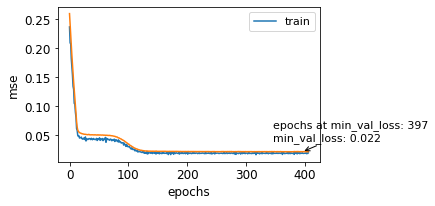

cc of val: 0.749893341984661


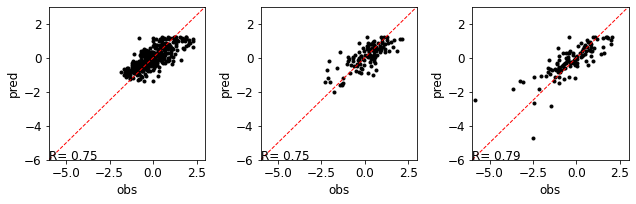

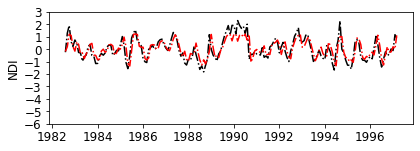

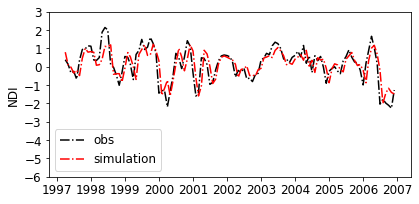

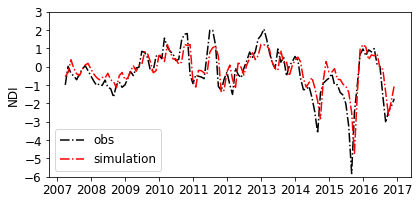

0.446950075700176
0.46504406374457297
0.5598672908264347


In [13]:
[outs,namex]=create_dir(namex0='T1M1_lag60')
# chay cai tao thu muc con truoc sau do load function
%run all_functions.ipynb
import pickle
#====================================================================
# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)

# import pandas as pd
df_all=pd.DataFrame(columns=['NAME','CC1','MAE1','CC2','MAE1','CC3','MAE3'],index=range(14))

##
###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names=['T1M1','T1M2','T1M3']
k=29
n_in0=3
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
# -----------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
# Chi lay NDI3 khac voi cac kich ban M3
df1=df0.iloc[:(2016-1968+1)*12,-1]

# =============================================================================

df2=series_to_supervised_df(pd.DataFrame(df1),n_in0,n_out0)

#################################################################################
df4=df2
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]
# print(train_df.shape,val_df.shape,test_df.shape)
x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
# x_train,y_train0=train_df.iloc[:,:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
# x_val,y_val0=val_df.iloc[:,:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.001, 0.999))
scaler_y = MinMaxScaler(feature_range=(0.001, 0.999))

# # Bo scale nhanh nhat
# scaler_x = MinMaxScaler(feature_range=(np.min(x_train), np.max(x_train)))
# scaler_y = MinMaxScaler(feature_range=(np.min(y_train), np.max(y_train)))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)
# n_features=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))

"""# Decide characters or time steps"""

# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
# n_features=1 # cai nay dung hon
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], y_train_scale.shape[1]))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], y_val_scale.shape[1]))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], y_test_scale.shape[1]))

# # TH2: xem no nhu 12 dac tinh
# n_step=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
# print(train_X.shape)

"""# Define model and setup training, save models

"""
if 'model' in locals(): # xoa di cac model tam thoi de khong bi anh huong bo nho
  # myVar exists.
  del model
tf.keras.backend.clear_session() # tranh viec chay di nhieu lan se lap lai cac lop
# =============================================================================
# # TH1:
# # n_features = train_X.shape[2]
# model = Sequential()
# # model.add(LSTM(64, activation='relu', return_sequences=False, 
# #                input_shape=(x_train_scale.shape[1], y_train_scale.shape[1])))
# model.add(LSTM(units=32,
#                activation='tanh', 
#                recurrent_activation='sigmoid', 
#                use_bias=True, 
#                kernel_initializer='glorot_uniform', 
#                recurrent_initializer='orthogonal',
#                bias_initializer='zeros',
#                unit_forget_bias=True,  
#                kernel_regularizer=None,
#                recurrent_regularizer=None,
#                bias_regularizer=None, 
#                activity_regularizer=None, 
#                kernel_constraint=None, 
#                recurrent_constraint=None, 
#                bias_constraint=None, 
#                dropout=0.0,  # rụng bớt weight khong tốt
#                recurrent_dropout=0.0, 
#                return_sequences=False, 
#                return_state=False, 
#                go_backwards=False, # input se doc nguoc
#                stateful=False,
#                time_major=False,  # chi su dung khi return_sequences true
#                unroll=False,
#                input_shape=(x_train_scale.shape[1], y_train_scale.shape[1]),
#                )
          
#           )

# # model.add(LSTM(32))
# model.add(Dense(y_train.shape[1]))

# Kiem tra voi mo hinh CNN
#==============================================================================
model = Sequential()
model.add(Conv1D(filters=3, kernel_size=3, activation='relu',
  input_shape=(x_train_scale.shape[1], y_train_scale.shape[1])))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(y_train_scale.shape[1]))
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
model.compile(optimizer=opt, loss='mse')
model.summary()

# =============================================================================
# =============================================================================
# # Define model
# # TH2:
# model = Sequential()
# model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
# model.compile(optimizer=opt, loss='mse')
# model.summary()

"""# Define callbacks"""

# Tao cac call back khac nhau 
###############################################################################
# NAME="T4-M1-TB-{}".format(int(time.time()))
NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
tsb=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
                                                     histogram_freq=1) # ket hop 
#####**************************************************
## IMPORTNANT 
# conditional call back
value00=0.028 # cho validation
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=value00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

###############
# condtion for training
# conditional call back
value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
from keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=value0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
es=keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=100,
mode="min",
) 

# checkpoint
mc=keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
)
    
  
##### callbacks
callbacks_list = [es,mc,tsb]

"""# TRAINING MODEL"""

## KHONG TRAINING NUA
# set seed de ket qua model khong bi thay doi
seed=123456789
import random
# import numpy as np
# import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
### == FITTING MODEL ##############################
# Fit model can bo sung them batchsize

history=model.fit(train_X,
          y_train_scale,
epochs=500,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale),
batch_size=36,sample_weight=None,
steps_per_epoch=12,
initial_epoch=12,
)


# # Save loss training
# # save loss training 
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


"""# Load results"""
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl',  'rb') as f3:
    # compressed_file = bz2.BZ2File(f, 'r')
    history = pickle.load(f3)

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras")
print("Loaded model from disk")



"""# Draw graphics"""

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
def get_results(loaded_model):
  #----------------------Important !!!!-----------------------#
  pred = loaded_model.predict(train_X)  #(predicted)  
  obs  = y_train_scale               #(obs) 
  #-----------------------------------------------------------#

  #----------------------reverse scaling------------------------------#
  #For training period
  y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
  y_rescaled = scaler_y.inverse_transform(obs)         #observed value

  #Inverse scaled --> pred, obs  
  pred = y_hat_rescaled
  obs = y_rescaled

  # pred1, obs1: pred train, obs train
  pred1=pred
  obs1=obs

  ##########################################################
  # Validation
  pred = loaded_model.predict(val_X)  #(pred)  
  obs  = y_val_scale                 #(obs) 
  #-----------------------------------------------------------#

  #----------------------reverse scaling------------------------------#
  #For training period
  y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
  y_rescaled = scaler_y.inverse_transform(obs)         #observed value

  #Inverse scaled --> pred, obs  
  pred = y_hat_rescaled
  obs = y_rescaled

  # pred1, obs1: pred val, obs val
  pred2=pred
  obs2=obs

  # ################################################################
  pred = loaded_model.predict(test_X)  #(pred)  
  obs  = y_test_scale                 #(obs) 
  #-----------------------------------------------------------#

  #----------------------reverse scaling------------------------------#
  #For training period
  y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
  y_rescaled = scaler_y.inverse_transform(obs)         #observed value

  #Inverse scaled --> pred, obs  
  pred = y_hat_rescaled
  obs = y_rescaled

  # pred1, obs1: pred val, obs val
  pred3=pred
  obs3=obs
  return obs1,pred1,obs2,pred2,obs3,pred3
# su dung functions sau khi loaded models
obs1,pred1,obs2,pred2,obs3,pred3=get_results(loaded_model=loaded_model)
#--------------------------------------------------------------------#
# THONG KE TAI DAY 
df_all_hinh=pd.DataFrame(columns=['NAME','CC1',
                                  'MAE1','CC2','MAE2',
                                  'CC3','MAE3'],index=range(14))
#--------------------------------------------------------------------#
df_all_hinh['NAME'][0]='T3M1'
# train
R1,ci1=pearsonr(obs1.flatten(),pred1.flatten())
MAE1=metrics.mean_absolute_error(obs1,pred1)
df_all_hinh['CC1'][0]=R1
df_all_hinh['MAE1'][0]=MAE1
# # val
# R2,ci2=pearsonr(obs2.flatten(),pred2.flatten())
# MAE2=metrics.mean_absolute_error(obs2,pred2)
# df_all_hinh['CC2'][0]=R2
# df_all_hinh['MAE2'][0]=MAE2
# test
R3,ci3=pearsonr(obs3.flatten(),pred3.flatten())
MAE3=metrics.mean_absolute_error(obs3,pred3)
df_all_hinh['CC3'][0]=R3
df_all_hinh['MAE3'][0]=MAE3
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# namex='T1M1_lag24'
df_train.to_csv('all_ts'+'/'+"train_"+ namex+'.csv')
df_val.to_csv('all_ts'+'/'+"val_"+ namex+'.csv')
df_test.to_csv('all_ts'+'/'+"test_"+ namex+'.csv')
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','testing']
CC=[]
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2

  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-6.0
    max_values=3.0

    plt.xlim(min_values,max_values)
    plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    CC.append(r2_vanila_1m)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
# for lead_time in range(1):
lead_time=0
fig,ax=plt.subplots(figsize=(6,4))
plt.ylim([-6,3])
plt.yticks([-6,-5,-4,-3,-2,-1,0,1,2,3])
plt.rcParams.update({'font.size': 12})

vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

plt.legend(['obs','simulation'])

plt.ylabel('NDI')
# plt.title('Time series '+'1 month' +' lead time prediction at trainning')
plt.tight_layout()

plt.subplot(212)
plt.ylim([-6,3])
plt.yticks([-6,-5,-4,-3,-2,-1,0,1,2,3])
plt.rcParams.update({'font.size': 12})

plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
plt.ylabel('NDI')
plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  plt.ylim([-6,3])
  plt.yticks([-6,-5,-4,-3,-2,-1,0,1,2,3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'val_time_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # TEST*************************************************************************
  
#Graph
months=['1month','2months','3months']
# for lead_time in range(1):
lead_time=0
fig,ax=plt.subplots(figsize=(6,3))
plt.subplot(111)
plt.rcParams.update({'font.size': 12})
plt.ylim([-6,3])
plt.yticks([-6,-5,-4,-3,-2,-1,0,1,2,3])
vector_date_test=vector_date[-24:]
plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
ts_T3M1=pred3[:,lead_time]
ts_T3M1obs=obs3[:,lead_time]
  # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
# plt.title('Time series '+'1month' +' lead time prediction at testing')
plt.tight_layout() 

plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'test_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
# =============================================================================
# Xuat me table o day

"""# LOAD  TENSORFBOARD"""

# %tensorboard --logdir logs/T4-M1-TB-2021/

# Tinh MAE
MAE_train=mean_absolute_error(obs1,pred1)
print(MAE_train)
MAE_val=mean_absolute_error(obs2,pred2)
print(MAE_val)
MAE_test=mean_absolute_error(obs3,pred3)
print(MAE_test)

"""# XUAT KET QUA RA CSV"""

# nhap thu vien tinh sai so
from sklearn import metrics
from scipy.stats import pearsonr
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
name_model=[]
mae=[]
rmse=[]
mape=[]
NSE=[]
# R2=[]
CC=[]
names_models=['training','validation','testing']
for i in range(3):
  # phases.append(phase_cho[i])
  name_model.append(names_models[i])
  # CC.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  mae.append(metrics.median_absolute_error(list_con[i]['obs'],list_con[i]['pred']))
  rmse.append(np.sqrt(metrics.mean_squared_error(list_con[i]['obs'],list_con[i]['pred'])))
  mape.append(np.sqrt(metrics.mean_absolute_percentage_error(list_con[i]['obs'],list_con[i]['pred'])))
  # R2.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  NSE.append(nse(list_con[i]['obs'],list_con[i]['pred']))
  list_con[i].to_csv(outs[2]+'/'+names[n_out0-1]+names_models[i]+'.csv')

###################
df_error=pd.DataFrame({'name_model':name_model,
'mae':mae,
'rmse':rmse,
'mape':mape,
'NSE':NSE,
# 'R2':R2,
# 'CC':CC,
})
# print(df_error)
# df_error.to_csv(outs[2]+'/'+names[n_out0-1]+'.csv')
# df_all.iloc[0,0]='T1M1'
# # df_all.iloc[0,1]=df_error.iloc[0,5]
# df_all.iloc[0,2]=df_error.iloc[0,1]
# df_all.iloc[0,3]=df_error.iloc[1,5]
# df_all.iloc[0,4]=df_error.iloc[1,1]
# df_all.iloc[0,5]=df_error.iloc[2,5]
# df_all.iloc[0,6]=df_error.iloc[2,1]
# print(df_all)

# P4. Du bao cho chinh no

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 11/1500
12/12 [==============================] - 2s 65ms/step - loss: 0.2490 - val_loss: 0.2571
Epoch 12/1500
12/12 [==============================] - 0s 14ms/step - loss: 0.1973 - val_loss: 0.2133
Epoch 13/1500
12/12 [==============================] - 0s 10ms/step - loss: 0.1718 - val_loss: 0.1708
Epoch 14/1500
12/12 [==============================] - 0s 11ms/step - loss: 0.1261 - val_loss: 0.1278
Epoch 15/1500
12/12 [=====================

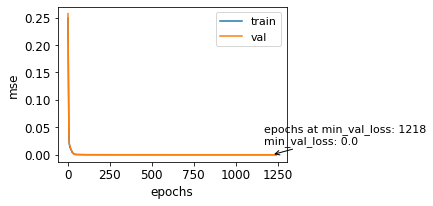

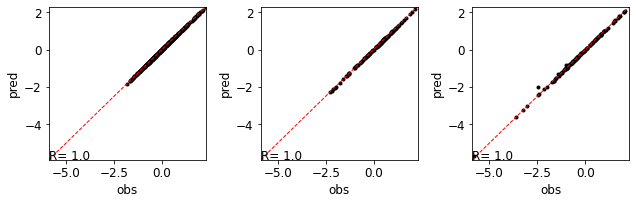

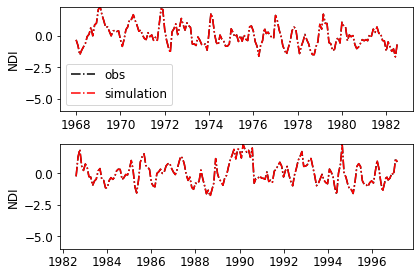

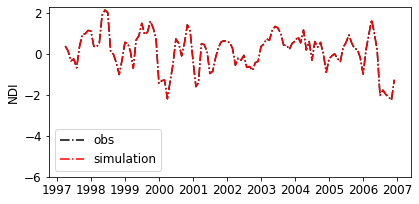

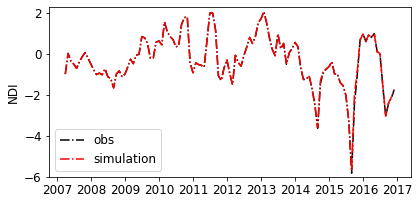

0.001293400347317722
0.0016333230943856942
0.01120170686616857
   name_model       mae      rmse           mape       NSE        CC
0    training  0.001095  0.001653       0.099229  0.999996  0.999998
1  validation  0.001141  0.002459  142146.159818  0.999993  0.999996
2     testing  0.001204  0.052824       0.096168  0.998115  0.999190
    NAME       CC1        MAE1       CC2        MAE1      CC3        MAE3
0   T1M1  0.999998  0.00109466  0.999996  0.00114072  0.99919  0.00120377
1    NaN       NaN         NaN       NaN         NaN      NaN         NaN
2    NaN       NaN         NaN       NaN         NaN      NaN         NaN
3    NaN       NaN         NaN       NaN         NaN      NaN         NaN
4    NaN       NaN         NaN       NaN         NaN      NaN         NaN
5    NaN       NaN         NaN       NaN         NaN      NaN         NaN
6    NaN       NaN         NaN       NaN         NaN      NaN         NaN
7    NaN       NaN         NaN       NaN         NaN      NaN        

In [ ]:
import os
[outs,namex]=create_dir(namex0='T4M1_lag60')
import pickle
# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)

# import pandas as pd
df_all=pd.DataFrame(columns=['NAME','CC1','MAE1','CC2','MAE1','CC3','MAE3'],index=range(14))

##
###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names=['T1M1','T1M2','T1M3']
k=29
n_in0=3
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
# -----------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
# Chi lay NDI3 khac voi cac kich ban M3
df1=df0.iloc[:(2016-1968+1)*12,-1]

# df1
# =============================================================================

df2=series_to_supervised_df(pd.DataFrame(df1),n_in0,n_out0)
df2

#################################################################################
df4=df2
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]
# print(train_df.shape,val_df.shape,test_df.shape)
# x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
x_train,y_train0=train_df.iloc[:,1:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

# x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
x_val,y_val0=val_df.iloc[:,1:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

# x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values

x_test,y_test0=test_df.iloc[:,1:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)
# n_features=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))

"""# Decide characters or time steps"""

# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
n_features=1 # cai nay dung hon
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))

# # TH2: xem no nhu 12 dac tinh
# n_step=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
# print(train_X.shape)

"""# Define model and setup training, save models

"""
if 'model' in locals(): # xoa di cac model tam thoi de khong bi anh huong bo nho
  # myVar exists.
  del model
tf.keras.backend.clear_session() # tranh viec chay di nhieu lan se lap lai cac lop
mape = tf.keras.losses.MeanAbsolutePercentageError()
# =============================================================================
# TH1:
n_features = train_X.shape[2]
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(n_in0, n_features)))
# model.add(LSTM(32))
model.add(Dense(y_train.shape[1]))
# =============================================================================
# =============================================================================
# # Define model
# # TH2:
# model = Sequential()
# model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
model.compile(optimizer=opt, loss='mse')
model.summary()

"""# Define callbacks"""

# Tao cac call back khac nhau 
###############################################################################
# NAME="T4-M1-TB-{}".format(int(time.time()))
NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
tensorboard_callback1=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
                                                     histogram_freq=1) # ket hop 
#####**************************************************
## IMPORTNANT 
# conditional call back
value00=0.028 # cho validation
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=value00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

###############
# condtion for training
# conditional call back
value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
from keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=value0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
    
    
  
##### callbacks
callbacks_list = [
# callbacks_threshole_val,
 # stopping
keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=100,
mode="min",
),

###################################################################

# checkpoint
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
),
# tensorboard,
tensorboard_callback1,
]
######################################################################
#

"""# TRAINING MODEL"""

## KHONG TRAINING NUA
# set seed de ket qua model khong bi thay doi
seed=123456789
import random
# import numpy as np
# import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
### == FITTING MODEL ##############################
# Fit model can bo sung them batchsize

history=model.fit(train_X,
          y_train_scale,
epochs=1500,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale),
batch_size=36,sample_weight=None,
steps_per_epoch=12,
initial_epoch=10,
)


# # Save loss training
# # save loss training 
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


"""# Load results"""
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl',  'rb') as f3:
    # compressed_file = bz2.BZ2File(f, 'r')
    history = pickle.load(f3)

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras")
print("Loaded model from disk")



"""# Draw graphics"""

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
# Tinh gia tri training, validation, testing
# su dung functions sau khi loaded models
obs1,pred1,obs2,pred2,obs3,pred3=get_results(loaded_model=loaded_model)
#--------------------------------------------------------------------#
# THONG KE TAI DAY 
df_all_hinh=pd.DataFrame(columns=['NAME','CC1',
                                  'MAE1','CC2','MAE2',
                                  'CC3','MAE3'],index=range(14))
#--------------------------------------------------------------------#
df_all_hinh['NAME'][0]='T3M1'
# train
R1,ci1=pearsonr(obs1.flatten(),pred1.flatten())
MAE1=metrics.mean_absolute_error(obs1,pred1)
df_all_hinh['CC1'][0]=R1
df_all_hinh['MAE1'][0]=MAE1
# val
R2,ci2=pearsonr(obs2.flatten(),pred2.flatten())
MAE2=metrics.mean_absolute_error(obs2,pred2)
df_all_hinh['CC2'][0]=R2
df_all_hinh['MAE2'][0]=MAE2
# test
R3,ci3=pearsonr(obs3.flatten(),pred3.flatten())
MAE3=metrics.mean_absolute_error(obs3,pred3)
df_all_hinh['CC3'][0]=R3
df_all_hinh['MAE3'][0]=MAE3
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# namex='T1M1_lag24'
df_train.to_csv('all_ts'+'/'+"train_"+ namex+'.csv')
df_val.to_csv('all_ts'+'/'+"val_"+ namex+'.csv')
df_test.to_csv('all_ts'+'/'+"test_"+ namex+'.csv')
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
# pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
# print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','validation','testing']
CC=[]
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2

  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-5.9
    max_values=2.29

    plt.xlim(min_values,max_values)
    plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    CC.append(r2_vanila_1m)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'val_time_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # TEST*************************************************************************
  
#Graph
months=['1month','2months','3months']
# for lead_time in range(1):
lead_time=0
fig,ax=plt.subplots(figsize=(6,3))
plt.subplot(111)
plt.rcParams.update({'font.size': 12})
plt.ylim([-6.0,2.3])
vector_date_test=vector_date[-24:]
plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
ts_T3M1=pred3[:,lead_time]
ts_T3M1obs=obs3[:,lead_time]
  # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
# plt.title('Time series '+'1month' +' lead time prediction at testing')
plt.tight_layout() 

plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'test_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
# =============================================================================
# Xuat me table o day

"""# LOAD  TENSORFBOARD"""

# %tensorboard --logdir logs/T4-M1-TB-2021/

# Tinh MAE
MAE_train=mean_absolute_error(obs1,pred1)
print(MAE_train)
MAE_val=mean_absolute_error(obs2,pred2)
print(MAE_val)
MAE_test=mean_absolute_error(obs3,pred3)
print(MAE_test)

"""# XUAT KET QUA RA CSV"""

# nhap thu vien tinh sai so
from sklearn import metrics
from scipy.stats import pearsonr
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
name_model=[]
mae=[]
rmse=[]
mape=[]
NSE=[]
# R2=[]
# CC=[]
names_models=['training','validation','testing']
for i in range(3):
  # phases.append(phase_cho[i])
  name_model.append(names_models[i])
  # CC.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  mae.append(metrics.median_absolute_error(list_con[i]['obs'],list_con[i]['pred']))
  rmse.append(np.sqrt(metrics.mean_squared_error(list_con[i]['obs'],list_con[i]['pred'])))
  mape.append(np.sqrt(metrics.mean_absolute_percentage_error(list_con[i]['obs'],list_con[i]['pred'])))
  # R2.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  NSE.append(nse(list_con[i]['obs'],list_con[i]['pred']))
  list_con[i].to_csv(outs[2]+'/'+names[n_out0-1]+names_models[i]+'.csv')

###################
df_error=pd.DataFrame({'name_model':name_model,
'mae':mae,
'rmse':rmse,
'mape':mape,
'NSE':NSE,
# 'R2':R2,
'CC':CC,
})
print(df_error)
df_error.to_csv(outs[2]+'/'+names[n_out0-1]+'.csv')
df_all.iloc[0,0]='T1M1'
df_all.iloc[0,1]=df_error.iloc[0,5]
df_all.iloc[0,2]=df_error.iloc[0,1]
df_all.iloc[0,3]=df_error.iloc[1,5]
df_all.iloc[0,4]=df_error.iloc[1,1]
df_all.iloc[0,5]=df_error.iloc[2,5]
df_all.iloc[0,6]=df_error.iloc[2,1]
print(df_all)

# P5. Sua gia tri du bao bang bang NDI tai thoi diem t

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 7/300
12/12 [==============================] - 3s 82ms/step - loss: 0.2091 - val_loss: 0.2036
Epoch 8/300
12/12 [==============================] - 0s 17ms/step - loss: 0.1483 - val_loss: 0.1304
Epoch 9/300
12/12 [==============================] - 0s 18ms/step - loss: 0.0792 - val_loss: 0.0547
Epoch 10/300
12/

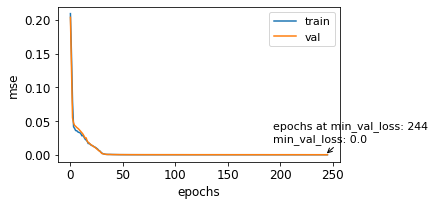

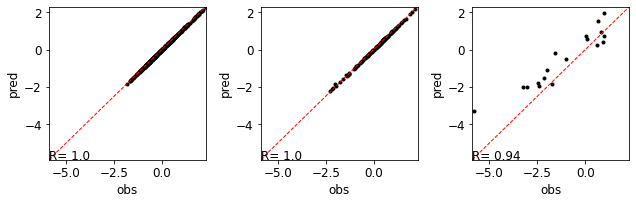

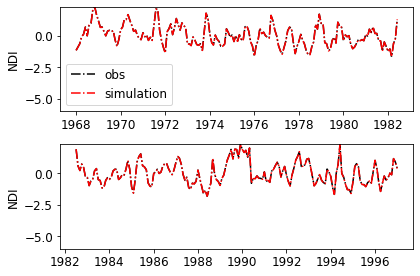

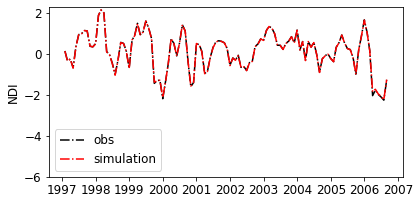

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:555: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


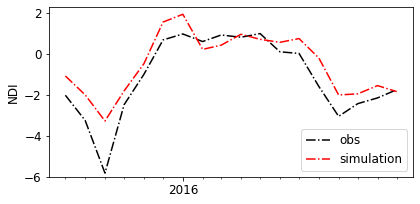

0.008716719597504665
0.011470888039932167
0.7695372005965975
   name_model       mae      rmse           mape       NSE        CC
0    training  0.007854  0.010232       0.208245  0.999857  0.999972
1  validation  0.008182  0.022251  799170.668260  0.999403  0.999753
2     testing  0.636622  0.947647       1.644677  0.564626  0.939492


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AAA_hybrid_separate')
%run all_functions.ipynb
# tao ra cac thu muc con
namex='T5M1_lag60'
outs=[namex+'/'+'save_model',
      namex+'/'+'save_pickles',
      namex+'/'+'tables',
      namex+'/'+'figs',
      namex+'/'+'loss']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)
import pickle
# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)


# Load mo hinh khi hau
m=0 # tinh cho 1 thang du bao
with open('input_pickles'+'/'+'PRS_NDIclim_sh.pkl', 'rb') as f2:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59kh = pickle.load(f2)[m]

# import pandas as pd
df_all=pd.DataFrame(columns=['NAME','CC1','MAE1','CC2','MAE1','CC3','MAE3'],index=range(14))

##
###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names=['T1M1','T1M2','T1M3']
k=29
n_in0=6
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
df0kh=PRS3_NDI3_59kh[k] # 1968-2020
# -----------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
# Chi lay NDI3 khac voi cac kich ban M3
df1=df0.iloc[:(2016-1968+1)*12,-1]

df1kh=df0kh.iloc[9:,-1]
df1obs=df0.iloc[(2014-1968+1)*12:(2016-1968+1)*12,-1]
# df1
# =============================================================================

df2=series_to_supervised_df(pd.DataFrame(df1),n_in0,n_out0)
# df0kh

df2kh=series_to_supervised_df(pd.DataFrame(df1kh),n_in0,n_out0)
# Tinh cho 24 thang cuoi thoi
df2kh=df2kh.iloc[-24:,:]
#################################################################################

df4=df2
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]

# lay gia tri index de ve do thi
test_df_org=test_df
# print(train_df.shape,val_df.shape,test_df.shape)
# x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
x_train,y_train0=train_df.iloc[:,1:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

# x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
x_val,y_val0=val_df.iloc[:,1:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

# x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values
# # Replace the last values by climate in test data set
df2kh
test_df=test_df.iloc[-df2kh.shape[0]:,:] # Bio chi kiem tra dung giai doan co du lieu khi hau
y_test0=test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,1:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
#THAY DOI GIA TRI CUA X TAI T BANG GIA TRI CUA KHI HAU
x_test1=test_df.iloc[:,1:].values.copy()
x_test2=df2kh.iloc[:,1:].values.copy()
x_test1[:,-1]=x_test2[:,-1].copy()
x_test=x_test1.copy()
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)

"""# Decide characters or time steps"""

# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
n_features=1 # cai nay dung hon
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], y_train.shape[1]))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], y_val.shape[1]))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], y_test.shape[1]))

# # TH2: xem no nhu 12 dac tinh
# n_step=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
# print(train_X.shape)

"""# Define model and setup training, save models

"""
if 'model' in locals(): # xoa di cac model tam thoi de khong bi anh huong bo nho
  # myVar exists.
  del model
tf.keras.backend.clear_session() # tranh viec chay di nhieu lan se lap lai cac lop
mape = tf.keras.losses.MeanAbsolutePercentageError()
# =============================================================================
# TH1:
n_features = train_X.shape[2]
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
# model.add(LSTM(32))
model.add(Dense(y_train.shape[1]))
# =============================================================================
# =============================================================================
# # Define model
# # TH2:
# model = Sequential()
# model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
model.compile(optimizer=opt, loss='mse')
model.summary()

"""# Define callbacks"""

# Tao cac call back khac nhau 
###############################################################################
# NAME="T4-M1-TB-{}".format(int(time.time()))
NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
tensorboard_callback1=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
                                                     histogram_freq=1) # ket hop 
#####**************************************************
## IMPORTNANT 
# conditional call back
value00=0.028 # cho validation
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=value00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

###############
# condtion for training
# conditional call back
value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
from keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=value0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
    
    
  
##### callbacks
callbacks_list = [
# callbacks_threshole_val,
 # stopping
keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=100,
mode="min",
),

###################################################################

# checkpoint
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
),
# tensorboard,
tensorboard_callback1,
]
######################################################################
#

"""# TRAINING MODEL"""

## KHONG TRAINING NUA
# set seed de ket qua model khong bi thay doi
seed=123456789
import random
# import numpy as np
# import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
### == FITTING MODEL ##############################
# Fit model can bo sung them batchsize

history=model.fit(train_X,
          y_train_scale,
epochs=300,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale),
batch_size=36,sample_weight=None,
steps_per_epoch=12,
initial_epoch=6,
)


# # Save loss training
# # save loss training 
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


"""# Load results"""
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl',  'rb') as f3:
    # compressed_file = bz2.BZ2File(f, 'r')
    history = pickle.load(f3)

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras")
print("Loaded model from disk")



"""# Draw graphics"""

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

##########################################################
# Validation
pred = loaded_model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs

################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#
# THONG KE TAI DAY 
df_all_hinh=pd.DataFrame(columns=['NAME','CC1',
                                  'MAE1','CC2','MAE2',
                                  'CC3','MAE3'],index=range(14))
#--------------------------------------------------------------------#
df_all_hinh['NAME'][0]='T3M1'
# train
R1,ci1=pearsonr(obs1.flatten(),pred1.flatten())
MAE1=metrics.mean_absolute_error(obs1,pred1)
df_all_hinh['CC1'][0]=R1
df_all_hinh['MAE1'][0]=MAE1
# val
R2,ci2=pearsonr(obs2.flatten(),pred2.flatten())
MAE2=metrics.mean_absolute_error(obs2,pred2)
df_all_hinh['CC2'][0]=R2
df_all_hinh['MAE2'][0]=MAE2
# test
R3,ci3=pearsonr(obs3.flatten(),pred3.flatten())
MAE3=metrics.mean_absolute_error(obs3,pred3)
df_all_hinh['CC3'][0]=R3
df_all_hinh['MAE3'][0]=MAE3
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# namex='T1M1_lag24'
df_train.to_csv('all_ts'+'/'+"train_"+ namex+'.csv')
df_val.to_csv('all_ts'+'/'+"val_"+ namex+'.csv')
df_test.to_csv('all_ts'+'/'+"test_"+ namex+'.csv')
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
# pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
# print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','validation','testing']
CC=[]
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2

  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-5.9
    max_values=2.29

    plt.xlim(min_values,max_values)
    plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    CC.append(r2_vanila_1m)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'val_time_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # TEST*************************************************************************
test_df_org1=test_df_org.iloc[-pred3.shape[0]:,:]
test_df_org1['pred']=''
test_df_org1['pred']=pred3
test_df_org1
#Graph
months=['1month','2months','3months']
# for lead_time in range(1):
lead_time=0
fig,ax=plt.subplots(figsize=(6,3))
plt.subplot(111)
plt.rcParams.update({'font.size': 12})
plt.ylim([-6.0,2.3])
# vector_date_test=vector_date[-24:]
# plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
# plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
# ts_T3M1=pred3[:,lead_time]
# ts_T3M1obs=obs3[:,lead_time]
plt.plot(test_df_org1.index.values.astype('datetime64',copy=False), test_df_org1['var1(t)'],'k-.')
plt.plot(test_df_org1.index.values.astype('datetime64',copy=False), test_df_org1['pred'],'r-.')
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')
# yearsFmt = DateFormatter('%Y-%m')
# yearsFmt = DateFormatter('%Y')
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

  # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
# plt.title('Time series '+'1month' +' lead time prediction at testing')
plt.tight_layout() 

plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'test_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
# =============================================================================
# Xuat me table o day

"""# LOAD  TENSORFBOARD"""

# %tensorboard --logdir logs/T4-M1-TB-2021/

# Tinh MAE
MAE_train=mean_absolute_error(obs1,pred1)
print(MAE_train)
MAE_val=mean_absolute_error(obs2,pred2)
print(MAE_val)
MAE_test=mean_absolute_error(obs,pred3)
print(MAE_test)

"""# XUAT KET QUA RA CSV"""

# nhap thu vien tinh sai so
from sklearn import metrics
from scipy.stats import pearsonr
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
name_model=[]
mae=[]
rmse=[]
mape=[]
NSE=[]
# R2=[]
# CC=[]
names_models=['training','validation','testing']
for i in range(3):
  # phases.append(phase_cho[i])
  name_model.append(names_models[i])
  # CC.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  mae.append(metrics.median_absolute_error(list_con[i]['obs'],list_con[i]['pred']))
  rmse.append(np.sqrt(metrics.mean_squared_error(list_con[i]['obs'],list_con[i]['pred'])))
  mape.append(np.sqrt(metrics.mean_absolute_percentage_error(list_con[i]['obs'],list_con[i]['pred'])))
  # R2.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  NSE.append(nse(list_con[i]['obs'],list_con[i]['pred']))
  list_con[i].to_csv(outs[2]+'/'+names[n_out0-1]+names_models[i]+'.csv')

###################
df_error=pd.DataFrame({'name_model':name_model,
'mae':mae,
'rmse':rmse,
'mape':mape,
'NSE':NSE,
# 'R2':R2,
'CC':CC,
})
print(df_error)
df_error.to_csv(outs[2]+'/'+names[n_out0-1]+'.csv')
df_all.iloc[0,0]='T1M1'
df_all.iloc[0,1]=df_error.iloc[0,5]
df_all.iloc[0,2]=df_error.iloc[0,1]
df_all.iloc[0,3]=df_error.iloc[1,5]
df_all.iloc[0,4]=df_error.iloc[1,1]
df_all.iloc[0,5]=df_error.iloc[2,5]
df_all.iloc[0,6]=df_error.iloc[2,1]

# P6. correction

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 7/1500
12/12 [==============================] - 4s 91ms/step - loss: 0.2063 - val_loss: 0.1997
Epoch 8/1500
12/12 [==============================] - 0s 19ms/step - loss: 0.1434 - val_loss: 0.1161
Epoch 9/1500
12/12 [==============================] - 0s 18ms/step - loss: 0.0663 - val_loss: 0.0424
Epoch 10/1500

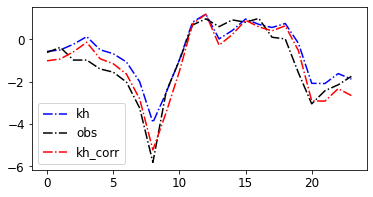

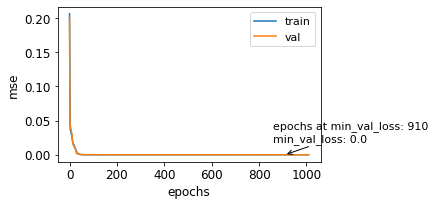

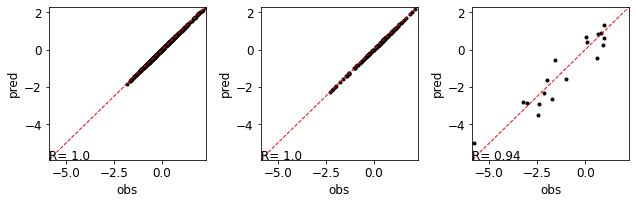

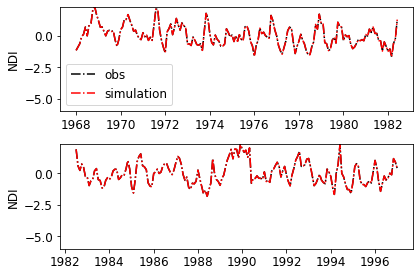

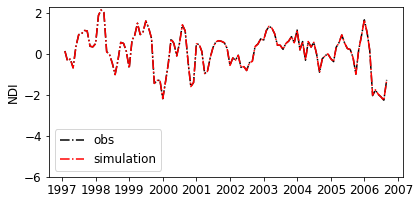

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:580: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


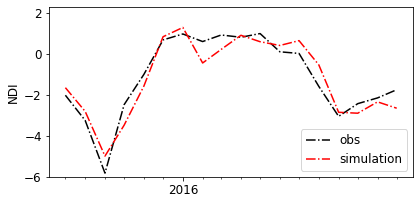

0.004306405226387789
0.0042590930079439305
0.5374091212948163
   name_model       mae      rmse           mape       NSE        CC
0    training  0.003891  0.005352       0.144637  0.999961  0.999986
1  validation  0.002908  0.005840  139129.419760  0.999960  0.999980
2     testing  0.453878  0.620376       1.506749  0.881557  0.943344
    NAME       CC1        MAE1      CC2        MAE1       CC3      MAE3
0   T1M1  0.999986  0.00389084  0.99998  0.00290848  0.943344  0.453878
1    NaN       NaN         NaN      NaN         NaN       NaN       NaN
2    NaN       NaN         NaN      NaN         NaN       NaN       NaN
3    NaN       NaN         NaN      NaN         NaN       NaN       NaN
4    NaN       NaN         NaN      NaN         NaN       NaN       NaN
5    NaN       NaN         NaN      NaN         NaN       NaN       NaN
6    NaN       NaN         NaN      NaN         NaN       NaN       NaN
7    NaN       NaN         NaN      NaN         NaN       NaN       NaN
8    NaN      

In [ ]:
import os
os.chdir('/content/drive/MyDrive/AAA_hybrid_separate')
%run all_functions.ipynb
# tao ra cac thu muc con
namex='T5M1_lag60_corr'
outs=[namex+'/'+'save_model',
      namex+'/'+'save_pickles',
      namex+'/'+'tables',
      namex+'/'+'figs',
      namex+'/'+'loss']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)
import pickle
# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)


# Load mo hinh khi hau
m=0 # tinh cho 1 thang du bao
with open('input_pickles'+'/'+'PRS_NDIclim_sh.pkl', 'rb') as f2:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59kh = pickle.load(f2)[m]

# import pandas as pd
df_all=pd.DataFrame(columns=['NAME','CC1','MAE1','CC2','MAE1','CC3','MAE3'],index=range(14))

##
###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names=['T1M1','T1M2','T1M3']
k=29
n_in0=6
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
df0kh=PRS3_NDI3_59kh[k] # 1968-2020
# -----------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
# Chi lay NDI3 khac voi cac kich ban M3
df1=df0.iloc[:(2016-1968+1)*12,-1]

df1kh=df0kh.iloc[9:,-1]
df1obs=df0.iloc[(2014-1968+1)*12:(2016-1968+1)*12,-1]

# df1
# =============================================================================
# =============================================================================
#   CORRECTION BIAS
from scipy.stats import linregress
# model_present: mo hinh khi hau
# ref_original : du lieu quan trac
def linear_correction(ref_original, model_present):
  model_present_sorted = np.sort(model_present)
  ref_original_sorted  = np.sort(ref_original)
  slope, intercept = linregress(model_present_sorted, ref_original_sorted)[0:2]
  model_present_corr=model_present * slope + intercept
  return model_present_corr # mo hinh khi hau tinh theo tuyen tinh

model_present_corr=linear_correction(df1obs.values,df1kh.values)
fig,ax=plt.subplots(figsize=(6,3))
plt.plot(df1kh.values,'b-.')
plt.plot(df1obs.values,'k-.')
plt.plot(model_present_corr,'r-.')
plt.legend(['kh','obs','kh_corr'])

df1kh_corr=df0kh.iloc[9:,-1]
df1kh_corr.iloc[:]=model_present_corr


#==============================================================================

df2=series_to_supervised_df(pd.DataFrame(df1),n_in0,n_out0)
# df0kh

df2kh=series_to_supervised_df(pd.DataFrame(df1kh_corr),n_in0,n_out0)
# Tinh cho 24 thang cuoi thoi
df2kh=df2kh.iloc[-24:,:]

#################################################################################

df4=df2
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]

# lay gia tri index de ve do thi
test_df_org=test_df
# print(train_df.shape,val_df.shape,test_df.shape)
# x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
x_train,y_train0=train_df.iloc[:,1:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

# x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
x_val,y_val0=val_df.iloc[:,1:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

# x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values
# # Replace the last values by climate in test data set
df2kh
test_df=test_df.iloc[-df2kh.shape[0]:,:] # Bio chi kiem tra dung giai doan co du lieu khi hau
y_test0=test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,1:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
#THAY DOI GIA TRI CUA X TAI T BANG GIA TRI CUA KHI HAU
x_test1=test_df.iloc[:,1:].values.copy()
x_test2=df2kh.iloc[:,1:].values.copy()
x_test1[:,-1]=x_test2[:,-1].copy()
x_test=x_test1.copy()
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)

"""# Decide characters or time steps"""

# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
n_features=1 # cai nay dung hon
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], y_train.shape[1]))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], y_val.shape[1]))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], y_test.shape[1]))

# # TH2: xem no nhu 12 dac tinh
# n_step=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
# print(train_X.shape)

"""# Define model and setup training, save models

"""
if 'model' in locals(): # xoa di cac model tam thoi de khong bi anh huong bo nho
  # myVar exists.
  del model
tf.keras.backend.clear_session() # tranh viec chay di nhieu lan se lap lai cac lop
mape = tf.keras.losses.MeanAbsolutePercentageError()
# =============================================================================
# TH1:
# n_features = train_X.shape[2]
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
# model.add(LSTM(32))
model.add(Dense(y_train.shape[1]))
# =============================================================================
# =============================================================================
# # Define model
# # TH2:
# model = Sequential()
# model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
model.compile(optimizer=opt, loss='mse')
model.summary()

"""# Define callbacks"""

# Tao cac call back khac nhau 
###############################################################################
# NAME="T4-M1-TB-{}".format(int(time.time()))
NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
tensorboard_callback1=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
                                                     histogram_freq=1) # ket hop 
#####**************************************************
## IMPORTNANT 
# conditional call back
value00=0.028 # cho validation
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=value00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

###############
# condtion for training
# conditional call back
value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
from keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=value0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
    
    
  
##### callbacks
callbacks_list = [
# callbacks_threshole_val,
 # stopping
keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=100,
mode="min",
),

###################################################################

# checkpoint
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
),
# tensorboard,
tensorboard_callback1,
]
######################################################################
#

"""# TRAINING MODEL"""

## KHONG TRAINING NUA
# set seed de ket qua model khong bi thay doi
seed=123456789
import random
# import numpy as np
# import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
### == FITTING MODEL ##############################
# Fit model can bo sung them batchsize

history=model.fit(train_X,
          y_train_scale,
epochs=1500,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale),
batch_size=36,sample_weight=None,
steps_per_epoch=12,
initial_epoch=6,
)


# # Save loss training
# # save loss training 
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


"""# Load results"""
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl',  'rb') as f3:
    # compressed_file = bz2.BZ2File(f, 'r')
    history = pickle.load(f3)

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras")
print("Loaded model from disk")



"""# Draw graphics"""

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

##########################################################
# Validation
pred = loaded_model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs

################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#
# THONG KE TAI DAY 
df_all_hinh=pd.DataFrame(columns=['NAME','CC1',
                                  'MAE1','CC2','MAE2',
                                  'CC3','MAE3'],index=range(14))
#--------------------------------------------------------------------#
df_all_hinh['NAME'][0]='T3M1'
# train
R1,ci1=pearsonr(obs1.flatten(),pred1.flatten())
MAE1=metrics.mean_absolute_error(obs1,pred1)
df_all_hinh['CC1'][0]=R1
df_all_hinh['MAE1'][0]=MAE1
# val
R2,ci2=pearsonr(obs2.flatten(),pred2.flatten())
MAE2=metrics.mean_absolute_error(obs2,pred2)
df_all_hinh['CC2'][0]=R2
df_all_hinh['MAE2'][0]=MAE2
# test
R3,ci3=pearsonr(obs3.flatten(),pred3.flatten())
MAE3=metrics.mean_absolute_error(obs3,pred3)
df_all_hinh['CC3'][0]=R3
df_all_hinh['MAE3'][0]=MAE3
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# namex='T1M1_lag24'
df_train.to_csv('all_ts'+'/'+"train_"+ namex+'.csv')
df_val.to_csv('all_ts'+'/'+"val_"+ namex+'.csv')
df_test.to_csv('all_ts'+'/'+"test_"+ namex+'.csv')
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
# pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
# print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','validation','testing']
CC=[]
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2

  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-5.9
    max_values=2.29

    plt.xlim(min_values,max_values)
    plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    CC.append(r2_vanila_1m)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'val_time_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # TEST*************************************************************************
test_df_org1=test_df_org.iloc[-pred3.shape[0]:,:]
test_df_org1['pred']=''
test_df_org1['pred']=pred3
test_df_org1
#Graph
months=['1month','2months','3months']
# for lead_time in range(1):
lead_time=0
fig,ax=plt.subplots(figsize=(6,3))
plt.subplot(111)
plt.rcParams.update({'font.size': 12})
plt.ylim([-6.0,2.3])
# vector_date_test=vector_date[-24:]
# plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
# plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
# ts_T3M1=pred3[:,lead_time]
# ts_T3M1obs=obs3[:,lead_time]
plt.plot(test_df_org1.index.values.astype('datetime64',copy=False), test_df_org1['var1(t)'],'k-.')
plt.plot(test_df_org1.index.values.astype('datetime64',copy=False), test_df_org1['pred'],'r-.')
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')
# yearsFmt = DateFormatter('%Y-%m')
# yearsFmt = DateFormatter('%Y')
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

  # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
# plt.title('Time series '+'1month' +' lead time prediction at testing')
plt.tight_layout() 

plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'test_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
# =============================================================================
# Xuat me table o day

"""# LOAD  TENSORFBOARD"""

# %tensorboard --logdir logs/T4-M1-TB-2021/

# Tinh MAE
MAE_train=mean_absolute_error(obs1,pred1)
print(MAE_train)
MAE_val=mean_absolute_error(obs2,pred2)
print(MAE_val)
MAE_test=mean_absolute_error(obs,pred3)
print(MAE_test)

"""# XUAT KET QUA RA CSV"""

# nhap thu vien tinh sai so
from sklearn import metrics
from scipy.stats import pearsonr
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
name_model=[]
mae=[]
rmse=[]
mape=[]
NSE=[]
# R2=[]
# CC=[]
names_models=['training','validation','testing']
for i in range(3):
  # phases.append(phase_cho[i])
  name_model.append(names_models[i])
  # CC.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  mae.append(metrics.median_absolute_error(list_con[i]['obs'],list_con[i]['pred']))
  rmse.append(np.sqrt(metrics.mean_squared_error(list_con[i]['obs'],list_con[i]['pred'])))
  mape.append(np.sqrt(metrics.mean_absolute_percentage_error(list_con[i]['obs'],list_con[i]['pred'])))
  # R2.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  NSE.append(nse(list_con[i]['obs'],list_con[i]['pred']))
  list_con[i].to_csv(outs[2]+'/'+names[n_out0-1]+names_models[i]+'.csv')

###################
df_error=pd.DataFrame({'name_model':name_model,
'mae':mae,
'rmse':rmse,
'mape':mape,
'NSE':NSE,
# 'R2':R2,
'CC':CC,
})
print(df_error)
df_error.to_csv(outs[2]+'/'+names[n_out0-1]+'.csv')
df_all.iloc[0,0]='T1M1'
df_all.iloc[0,1]=df_error.iloc[0,5]
df_all.iloc[0,2]=df_error.iloc[0,1]
df_all.iloc[0,3]=df_error.iloc[1,5]
df_all.iloc[0,4]=df_error.iloc[1,1]
df_all.iloc[0,5]=df_error.iloc[2,5]
df_all.iloc[0,6]=df_error.iloc[2,1]
print(df_all)

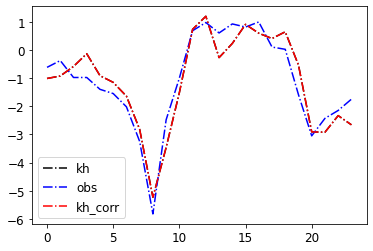

In [ ]:
# https://www.linkedin.com/pulse/build-simple-statistical-bias-correction-model-4-lines-chonghua-yin
"""       
The method is similar to the algorithm proposed by Stoner et al (2013).
Stoner et al (2013) An asynchronous regional regression model for statistical downscaling of
daily climate variables.

Remove the model biases by fitting a linear regression model with sorted observational and model datasets.

ref_original, model_present - 1D array_like. Both arrays should have the same length.     

:returns: downscaled model_present and model_future
    """
from scipy.stats import linregress

def sorted_regression(ref_original, model_present, model_future):
  

    model_present_sorted = np.sort(model_present)
    ref_original_sorted  = np.sort(ref_original)
    
    slope, intercept = linregress(model_present_sorted, ref_original_sorted)[0:2]
    return model_present * slope + intercept, model_future * slope + intercept

# application
model_present=df1kh.values
ref_original=df1obs.values
model_present_sorted = np.sort(model_present)
ref_original_sorted  = np.sort(ref_original)

from scipy.stats import linregress
# model_present: mo hinh khi hau
# ref_original : du lieu quan trac
def linear_correction(ref_original, model_present):
  model_present_sorted = np.sort(model_present)
  ref_original_sorted  = np.sort(ref_original)
  slope, intercept = linregress(model_present_sorted, ref_original_sorted)[0:2]
  model_present_corr=model_present * slope + intercept
  return model_present_corr # mo hinh khi hau tinh theo tuyen tinh

model_present_corr=linear_correction(df1obs.values,df1kh.values)
plt.plot(df1kh.values,'k-.')
plt.plot(df1obs.values,'b-.')
plt.plot(model_present_corr,'r-.')
plt.legend(['kh','obs','kh_corr'])








# P7. Predict bias values

In [ ]:
import os
os.chdir('/content/drive/MyDrive/AAA_hybrid_separate')
%run all_functions.ipynb
# tao ra cac thu muc con
namex='T5M1_lag60_double'
outs=[namex+'/'+'save_model',
      namex+'/'+'save_pickles',
      namex+'/'+'tables',
      namex+'/'+'figs',
      namex+'/'+'loss']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)
import pickle
# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)


# Load mo hinh khi hau
m=0 # tinh cho 1 thang du bao
with open('input_pickles'+'/'+'list_NDIclim_1417.pkl', 'rb') as f2:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59kh = pickle.load(f2)[m]

# import pandas as pd
df_all=pd.DataFrame(columns=['NAME','CC1','MAE1','CC2','MAE1','CC3','MAE3'],index=range(14))

##
###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names=['T1M1','T1M2','T1M3']
k=29
n_in0=3
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
df0kh=PRS3_NDI3_59kh[k] # 1968-2020
# -----------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
# Chi lay NDI3 khac voi cac kich ban M3
df1=df0.iloc[:(2016-1968+1)*12,-1]

df1kh=df0kh.iloc[:,-1]
df1obs=df0.iloc[(2013-1968+1)*12:(2017-1968+1)*12,-1]
kh_obs=df1kh.values-df1obs.values
kh_obs

array([ 0.  ,  0.  ,  0.  ,  0.89,  0.54,  0.43,  1.37,  0.7 ,  1.19,
        0.07,  0.39,  0.18,  0.05, -0.12,  0.75,  1.11,  0.91,  0.87,
        0.95,  1.24,  1.89, -0.04,  0.03,  0.14,  0.22, -0.58, -0.5 ,
        0.15, -0.28,  0.46,  0.73,  1.4 ,  0.97,  0.34,  0.53, -0.13,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ])

In [ ]:
df5=pd.DataFrame({'kh':df1kh,'obs':df1obs.values,'bias':kh_obs})
df5
df6=series_to_supervised_df(df5,n_in0,n_out0)
df6.shape
# df6

(45, 12)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 7/300
12/12 [==============================] - 3s 59ms/step - loss: 0.2585
Epoch 8/300
12/12 [==============================] - 0s 19ms/step - loss: 0.2033
Epoch 9/300
12/12 [==============================] - 0s 17ms/step - loss: 0.1527
Epoch 10/300
12/12 [==============================] - 0s 19ms/step - loss

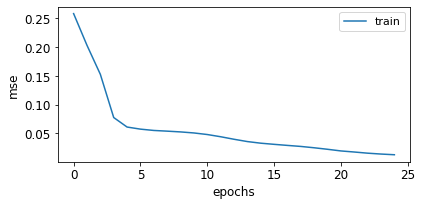

In [ ]:
df4=df6
n_train=int(df4.shape[0]*0.6)
n_test=df4.shape[0]-n_train

train_df=df4.iloc[0:n_train,:]
test_df=df4.iloc[n_train:,:]

# lay gia tri index de ve do thi
test_df_org=test_df
# print(train_df.shape,val_df.shape,test_df.shape)
x_train,y_train0=train_df.iloc[:,:-2].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
# x_train,y_train0=train_df.iloc[:,1:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
x_test,y_test0=test_df.iloc[:,:-2].values,test_df.iloc[:,-1].values # bo di thang obs tai t
# x_test,y_test0=test_df.iloc[:,1:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)

"""# Decide characters or time steps"""

# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
# n_features=1 # cai nay dung hon
# # TH1 : Xem no nhu 12 buoc thoi gian
n_features=1 # cai nay dung hon
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], y_train.shape[1]))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], y_val.shape[1]))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], y_test.shape[1]))

# # TH2: xem no nhu 12 dac tinh
# n_step=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
# print(train_X.shape)

"""# Define model and setup training, save models

"""
if 'model' in locals(): # xoa di cac model tam thoi de khong bi anh huong bo nho
  # myVar exists.
  del model
tf.keras.backend.clear_session() # tranh viec chay di nhieu lan se lap lai cac lop
mape = tf.keras.losses.MeanAbsolutePercentageError()
# =============================================================================
# TH1:
# n_features = train_X.shape[2]
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
# model.add(LSTM(32))
model.add(Dense(y_train.shape[1]))
# =============================================================================
# =============================================================================
# # Define model
# # TH2:
# model = Sequential()
# model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
model.compile(optimizer=opt, loss='mse')
model.summary()

"""# Define callbacks"""

# Tao cac call back khac nhau 
###############################################################################
# NAME="T4-M1-TB-{}".format(int(time.time()))
NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
tensorboard_callback1=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
                                                     histogram_freq=1) # ket hop 
#####**************************************************
## IMPORTNANT 
# conditional call back
value00=0.028 # cho validation
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=value00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

###############
# condtion for training
# conditional call back
value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
from keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=value0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
    
    
  
##### callbacks
callbacks_list = [
# callbacks_threshole_val,
 # stopping
keras.callbacks.EarlyStopping(
monitor="loss",
patience=100,
mode="min",
),

###################################################################

# checkpoint
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras", # cong them buoc thoi gian
monitor="loss",
save_best_only=True,
),
# tensorboard,
tensorboard_callback1,
]
######################################################################
#

"""# TRAINING MODEL"""

## KHONG TRAINING NUA
# set seed de ket qua model khong bi thay doi
seed=123456789
import random
# import numpy as np
# import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
### == FITTING MODEL ##############################
# Fit model can bo sung them batchsize

history=model.fit(train_X,
          y_train_scale,
epochs=300,
callbacks=callbacks_list,
# validation_data=(val_X,y_val_scale),
batch_size=36,sample_weight=None,
steps_per_epoch=12,
initial_epoch=6,
)


# # Save loss training
# # save loss training 
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


"""# Load results"""
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl',  'rb') as f3:
    # compressed_file = bz2.BZ2File(f, 'r')
    history = pickle.load(f3)

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras")
print("Loaded model from disk")



"""# Draw graphics"""

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history['loss'])
# # plt.plot(history['val_loss'])
# # Draw the minimum epochs 
# df_val_loss=pd.DataFrame({'val_loss':history['val_loss']})
# # print(df_val_loss)
# idxmin=df_val_loss[['val_loss']].idxmin().values
# val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
# print(idxmin,val_loss_min_values)
# plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
#              xy=(idxmin,val_loss_min_values), xycoords='data',
#             xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
#             arrowprops=dict(arrowstyle="->",
#                             connectionstyle="arc3"),
#             )

plt.legend(['train'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

# ##########################################################
# # Validation
# pred = loaded_model.predict(val_X)  #(pred)  
# obs  = y_val_scale                 #(obs) 
# #-----------------------------------------------------------#

# #----------------------reverse scaling------------------------------#
# #For training period
# y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
# y_rescaled = scaler_y.inverse_transform(obs)         #observed value

# #Inverse scaled --> pred, obs  
# pred = y_hat_rescaled
# obs = y_rescaled

# # pred1, obs1: pred val, obs val
# pred2=pred
# obs2=obs

# ################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#
# THONG KE TAI DAY 
df_all_hinh=pd.DataFrame(columns=['NAME','CC1',
                                  'MAE1','CC2','MAE2',
                                  'CC3','MAE3'],index=range(14))
#--------------------------------------------------------------------#
df_all_hinh['NAME'][0]='T3M1'
# train
R1,ci1=pearsonr(obs1.flatten(),pred1.flatten())
MAE1=metrics.mean_absolute_error(obs1,pred1)
df_all_hinh['CC1'][0]=R1
df_all_hinh['MAE1'][0]=MAE1
# # val
# R2,ci2=pearsonr(obs2.flatten(),pred2.flatten())
# MAE2=metrics.mean_absolute_error(obs2,pred2)
# df_all_hinh['CC2'][0]=R2
# df_all_hinh['MAE2'][0]=MAE2
# test
R3,ci3=pearsonr(obs3.flatten(),pred3.flatten())
MAE3=metrics.mean_absolute_error(obs3,pred3)
df_all_hinh['CC3'][0]=R3
df_all_hinh['MAE3'][0]=MAE3
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
# df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
# list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# namex='T1M1_lag24'
df_train.to_csv('all_ts'+'/'+"train_"+ namex+'.csv')
# df_val.to_csv('all_ts'+'/'+"val_"+ namex+'.csv')
df_test.to_csv('all_ts'+'/'+"test_"+ namex+'.csv')
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
# pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
# print('cc of val: '+str(pearson))

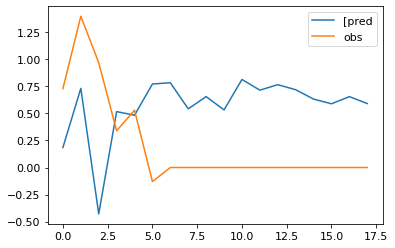

In [ ]:
# print(df1obs)
plt.plot(pred3)
plt.plot(obs3)
# obs3
plt.legend(['[pred','obs'])

# data after correction

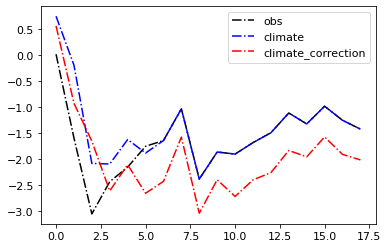

In [ ]:
df1kh_pred_org=df1kh.iloc[-pred3.shape[0]:].copy()
df1obs_org=df1obs.iloc[-pred3.shape[0]:].copy()

df1kh_pred_org_corr=df1kh_pred_org.values-pred3.flatten()
#
plt.plot(df1obs_org.values,'k-.')
plt.plot(df1kh_pred_org.values,'b-.')
plt.plot(df1kh_pred_org_corr,'r-.')
plt.legend(['obs','climate','climate_correction'])


# P8. Predict after bias correction

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 7/300
12/12 [==============================] - 3s 78ms/step - loss: 0.2203 - val_loss: 0.2234
Epoch 8/300
12/12 [==============================] - 0s 17ms/step - loss: 0.1738 - val_loss: 0.1566
Epoch 9/300
12/12 [==============================] - 0s 18ms/step - loss: 0.1004 - val_loss: 0.0769
Epoch 10/300
12/

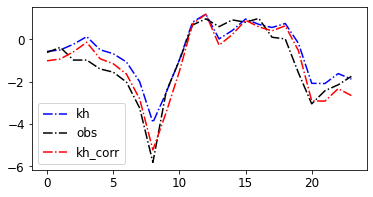

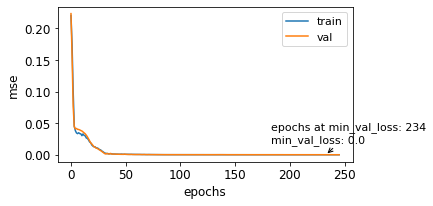

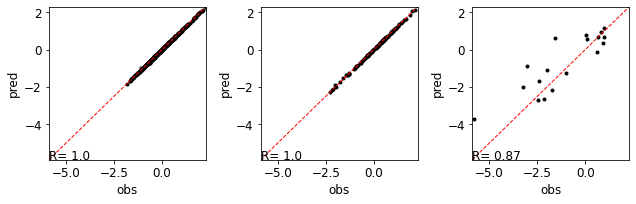

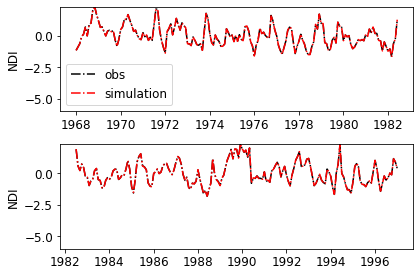

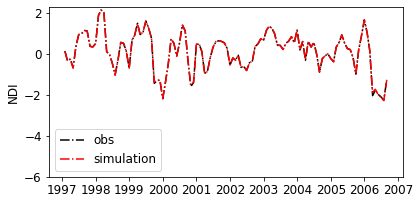

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


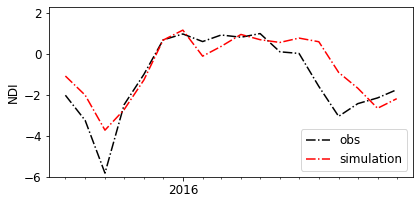

0.009579326254609208
0.012939297235249711
0.7730621947844823
   name_model       mae      rmse           mape       NSE        CC
0    training  0.007071  0.013182       0.241746  0.999763  0.999882
1  validation  0.009064  0.022058  491384.422681  0.999419  0.999722
2     testing  0.530883  1.028298       1.648702  0.515985  0.868228
    NAME       CC1       MAE1       CC2        MAE1       CC3      MAE3
0   T1M1  0.999882  0.0070706  0.999722  0.00906444  0.868228  0.530883
1    NaN       NaN        NaN       NaN         NaN       NaN       NaN
2    NaN       NaN        NaN       NaN         NaN       NaN       NaN
3    NaN       NaN        NaN       NaN         NaN       NaN       NaN
4    NaN       NaN        NaN       NaN         NaN       NaN       NaN
5    NaN       NaN        NaN       NaN         NaN       NaN       NaN
6    NaN       NaN        NaN       NaN         NaN       NaN       NaN
7    NaN       NaN        NaN       NaN         NaN       NaN       NaN
8    NaN       

In [ ]:
import os
os.chdir('/content/drive/MyDrive/AAA_hybrid_separate')
%run all_functions.ipynb
# tao ra cac thu muc con
namex='T5M1_lag60_corr_pred'
outs=[namex+'/'+'save_model',
      namex+'/'+'save_pickles',
      namex+'/'+'tables',
      namex+'/'+'figs',
      namex+'/'+'loss']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)
import pickle
# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)


# Load mo hinh khi hau
m=0 # tinh cho 1 thang du bao
with open('input_pickles'+'/'+'PRS_NDIclim_sh.pkl', 'rb') as f2:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59kh = pickle.load(f2)[m]

# import pandas as pd
df_all=pd.DataFrame(columns=['NAME','CC1','MAE1','CC2','MAE1','CC3','MAE3'],index=range(14))

##
###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names=['T1M1','T1M2','T1M3']
k=29
n_in0=6
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
df0kh=PRS3_NDI3_59kh[k] # 1968-2020
# -----------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
# Chi lay NDI3 khac voi cac kich ban M3
df1=df0.iloc[:(2016-1968+1)*12,-1]

df1kh=df0kh.iloc[9:,-1]
df1obs=df0.iloc[(2014-1968+1)*12:(2016-1968+1)*12,-1]

# df1
# =============================================================================
# =============================================================================
#   CORRECTION BIAS
from scipy.stats import linregress
# model_present: mo hinh khi hau
# ref_original : du lieu quan trac
def linear_correction(ref_original, model_present):
  model_present_sorted = np.sort(model_present)
  ref_original_sorted  = np.sort(ref_original)
  slope, intercept = linregress(model_present_sorted, ref_original_sorted)[0:2]
  model_present_corr=model_present * slope + intercept
  return model_present_corr # mo hinh khi hau tinh theo tuyen tinh

model_present_corr=linear_correction(df1obs.values,df1kh.values)
fig,ax=plt.subplots(figsize=(6,3))
plt.plot(df1kh.values,'b-.')
plt.plot(df1obs.values,'k-.')
plt.plot(model_present_corr,'r-.')
plt.legend(['kh','obs','kh_corr'])

df1kh_corr=df0kh.iloc[9:,-1]
# df1kh_corr.iloc[:]=model_present_corr

df1kh_corr.iloc[-5:]=df1kh_pred_org_corr[:-13] # CAP NHAT DU LIEU KHI HAU

#==============================================================================

df2=series_to_supervised_df(pd.DataFrame(df1),n_in0,n_out0)
# df0kh

df2kh=series_to_supervised_df(pd.DataFrame(df1kh_corr),n_in0,n_out0)
# Tinh cho 24 thang cuoi thoi
df2kh=df2kh.iloc[-24:,:]

#################################################################################

df4=df2
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]

# lay gia tri index de ve do thi
test_df_org=test_df
# print(train_df.shape,val_df.shape,test_df.shape)
# x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
x_train,y_train0=train_df.iloc[:,1:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

# x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
x_val,y_val0=val_df.iloc[:,1:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

# x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values
# # Replace the last values by climate in test data set
df2kh
test_df=test_df.iloc[-df2kh.shape[0]:,:] # Bio chi kiem tra dung giai doan co du lieu khi hau
y_test0=test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,1:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
#THAY DOI GIA TRI CUA X TAI T BANG GIA TRI CUA KHI HAU
x_test1=test_df.iloc[:,1:].values.copy()
x_test2=df2kh.iloc[:,1:].values.copy()
x_test1[:,-1]=x_test2[:,-1].copy()
x_test=x_test1.copy()
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)

"""# Decide characters or time steps"""

# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
n_features=1 # cai nay dung hon
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], y_train.shape[1]))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], y_val.shape[1]))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], y_test.shape[1]))

# # TH2: xem no nhu 12 dac tinh
# n_step=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
# print(train_X.shape)

"""# Define model and setup training, save models

"""
if 'model' in locals(): # xoa di cac model tam thoi de khong bi anh huong bo nho
  # myVar exists.
  del model
tf.keras.backend.clear_session() # tranh viec chay di nhieu lan se lap lai cac lop
mape = tf.keras.losses.MeanAbsolutePercentageError()
# =============================================================================
# TH1:
# n_features = train_X.shape[2]
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
# model.add(LSTM(32))
model.add(Dense(y_train.shape[1]))
# =============================================================================
# =============================================================================
# # Define model
# # TH2:
# model = Sequential()
# model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
model.compile(optimizer=opt, loss='mse')
model.summary()

"""# Define callbacks"""

# Tao cac call back khac nhau 
###############################################################################
# NAME="T4-M1-TB-{}".format(int(time.time()))
NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
tensorboard_callback1=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
                                                     histogram_freq=1) # ket hop 
#####**************************************************
## IMPORTNANT 
# conditional call back
value00=0.028 # cho validation
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=value00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

###############
# condtion for training
# conditional call back
value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
from keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=value0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
    
    
  
##### callbacks
callbacks_list = [
# callbacks_threshole_val,
 # stopping
keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=100,
mode="min",
),

###################################################################

# checkpoint
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
),
# tensorboard,
tensorboard_callback1,
]
######################################################################
#

"""# TRAINING MODEL"""

## KHONG TRAINING NUA
# set seed de ket qua model khong bi thay doi
seed=123456789
import random
# import numpy as np
# import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
### == FITTING MODEL ##############################
# Fit model can bo sung them batchsize

history=model.fit(train_X,
          y_train_scale,
epochs=300,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale),
batch_size=36,sample_weight=None,
steps_per_epoch=12,
initial_epoch=6,
)


# # Save loss training
# # save loss training 
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


"""# Load results"""
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl',  'rb') as f3:
    # compressed_file = bz2.BZ2File(f, 'r')
    history = pickle.load(f3)

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras")
print("Loaded model from disk")



"""# Draw graphics"""

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

##########################################################
# Validation
pred = loaded_model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs

################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#
# THONG KE TAI DAY 
df_all_hinh=pd.DataFrame(columns=['NAME','CC1',
                                  'MAE1','CC2','MAE2',
                                  'CC3','MAE3'],index=range(14))
#--------------------------------------------------------------------#
df_all_hinh['NAME'][0]='T3M1'
# train
R1,ci1=pearsonr(obs1.flatten(),pred1.flatten())
MAE1=metrics.mean_absolute_error(obs1,pred1)
df_all_hinh['CC1'][0]=R1
df_all_hinh['MAE1'][0]=MAE1
# val
R2,ci2=pearsonr(obs2.flatten(),pred2.flatten())
MAE2=metrics.mean_absolute_error(obs2,pred2)
df_all_hinh['CC2'][0]=R2
df_all_hinh['MAE2'][0]=MAE2
# test
R3,ci3=pearsonr(obs3.flatten(),pred3.flatten())
MAE3=metrics.mean_absolute_error(obs3,pred3)
df_all_hinh['CC3'][0]=R3
df_all_hinh['MAE3'][0]=MAE3
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# namex='T1M1_lag24'
df_train.to_csv('all_ts'+'/'+"train_"+ namex+'.csv')
df_val.to_csv('all_ts'+'/'+"val_"+ namex+'.csv')
df_test.to_csv('all_ts'+'/'+"test_"+ namex+'.csv')
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
# pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
# print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','validation','testing']
CC=[]
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2

  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-5.9
    max_values=2.29

    plt.xlim(min_values,max_values)
    plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    CC.append(r2_vanila_1m)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'val_time_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # TEST*************************************************************************
test_df_org1=test_df_org.iloc[-pred3.shape[0]:,:]
test_df_org1['pred']=''
test_df_org1['pred']=pred3
test_df_org1
#Graph
months=['1month','2months','3months']
# for lead_time in range(1):
lead_time=0
fig,ax=plt.subplots(figsize=(6,3))
plt.subplot(111)
plt.rcParams.update({'font.size': 12})
plt.ylim([-6.0,2.3])
# vector_date_test=vector_date[-24:]
# plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
# plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
# ts_T3M1=pred3[:,lead_time]
# ts_T3M1obs=obs3[:,lead_time]
plt.plot(test_df_org1.index.values.astype('datetime64',copy=False), test_df_org1['var1(t)'],'k-.')
plt.plot(test_df_org1.index.values.astype('datetime64',copy=False), test_df_org1['pred'],'r-.')
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')
# yearsFmt = DateFormatter('%Y-%m')
# yearsFmt = DateFormatter('%Y')
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

  # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
# plt.title('Time series '+'1month' +' lead time prediction at testing')
plt.tight_layout() 

plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'test_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
# =============================================================================
# Xuat me table o day

"""# LOAD  TENSORFBOARD"""

# %tensorboard --logdir logs/T4-M1-TB-2021/

# Tinh MAE
MAE_train=mean_absolute_error(obs1,pred1)
print(MAE_train)
MAE_val=mean_absolute_error(obs2,pred2)
print(MAE_val)
MAE_test=mean_absolute_error(obs,pred3)
print(MAE_test)

"""# XUAT KET QUA RA CSV"""

# nhap thu vien tinh sai so
from sklearn import metrics
from scipy.stats import pearsonr
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
name_model=[]
mae=[]
rmse=[]
mape=[]
NSE=[]
# R2=[]
# CC=[]
names_models=['training','validation','testing']
for i in range(3):
  # phases.append(phase_cho[i])
  name_model.append(names_models[i])
  # CC.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  mae.append(metrics.median_absolute_error(list_con[i]['obs'],list_con[i]['pred']))
  rmse.append(np.sqrt(metrics.mean_squared_error(list_con[i]['obs'],list_con[i]['pred'])))
  mape.append(np.sqrt(metrics.mean_absolute_percentage_error(list_con[i]['obs'],list_con[i]['pred'])))
  # R2.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  NSE.append(nse(list_con[i]['obs'],list_con[i]['pred']))
  list_con[i].to_csv(outs[2]+'/'+names[n_out0-1]+names_models[i]+'.csv')

###################
df_error=pd.DataFrame({'name_model':name_model,
'mae':mae,
'rmse':rmse,
'mape':mape,
'NSE':NSE,
# 'R2':R2,
'CC':CC,
})
print(df_error)
df_error.to_csv(outs[2]+'/'+names[n_out0-1]+'.csv')
df_all.iloc[0,0]='T1M1'
df_all.iloc[0,1]=df_error.iloc[0,5]
df_all.iloc[0,2]=df_error.iloc[0,1]
df_all.iloc[0,3]=df_error.iloc[1,5]
df_all.iloc[0,4]=df_error.iloc[1,1]
df_all.iloc[0,5]=df_error.iloc[2,5]
df_all.iloc[0,6]=df_error.iloc[2,1]
print(df_all)

# II) Seperate prediction

## Predict precipitation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 11/1500
12/12 [==============================] - 3s 70ms/step - loss: 0.0903 - val_loss: 0.1213
Epoch 12/1500
12/12 [==============================] - 0s 10ms/step - loss: 0.0793 - val_loss: 0.1040
Epoch 13/1500
12/12 [==============================] - 0s 10ms/step - loss: 0.0592 - val_loss: 0.0889
Epoch 14/1500
12/12 [==============================] - 0s 10ms/step - loss: 0.0522 - val_loss: 0.0756
Epoch 15/1500
12/12 [=====================

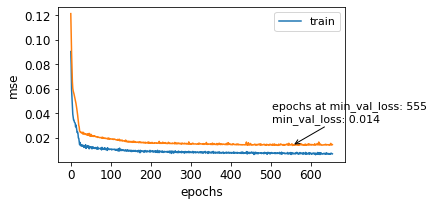

cc of val: 0.8954922437984998


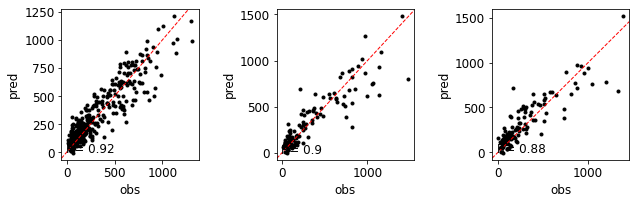

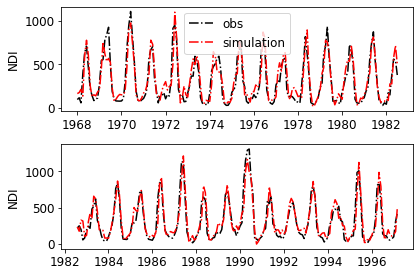

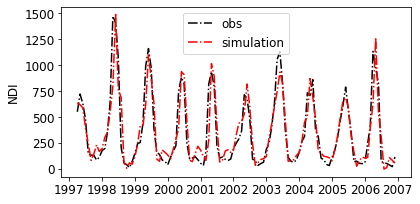

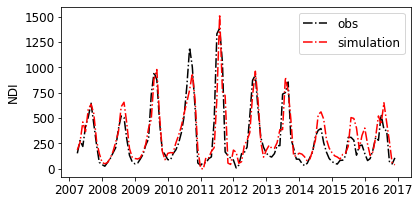

84.08985808353478
102.99196060683991
100.3374925137381


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AAA_hybrid_separate')
%run all_functions.ipynb
# tao ra cac thu muc con
namex='T1M1_precipitation'
outs=[namex+'/'+'save_model',
      namex+'/'+'save_pickles',
      namex+'/'+'tables',
      namex+'/'+'figs',
      namex+'/'+'loss']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)
import pickle
# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)

# import pandas as pd
df_all=pd.DataFrame(columns=['NAME','CC1','MAE1','CC2','MAE1','CC3','MAE3'],index=range(14))

##
###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names=['T1M1','T1M2','T1M3']
k=29
n_in0=3
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
# -----------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
# Chi lay NDI3 khac voi cac kich ban M3
df1=df0.iloc[:(2016-1968+1)*12,-4]

# df1
# =============================================================================

df2=series_to_supervised_df(pd.DataFrame(df1),n_in0,n_out0)
df2

#################################################################################
df4=df2
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]
# print(train_df.shape,val_df.shape,test_df.shape)
x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
# x_train,y_train0=train_df.iloc[:,:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
# x_val,y_val0=val_df.iloc[:,:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)
# n_features=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))

"""# Decide characters or time steps"""

# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
n_features=1 # cai nay dung hon
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))

# # TH2: xem no nhu 12 dac tinh
# n_step=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
# print(train_X.shape)

"""# Define model and setup training, save models

"""
if 'model' in locals(): # xoa di cac model tam thoi de khong bi anh huong bo nho
  # myVar exists.
  del model
tf.keras.backend.clear_session() # tranh viec chay di nhieu lan se lap lai cac lop
mape = tf.keras.losses.MeanAbsolutePercentageError()
# =============================================================================
# TH1:
n_features = train_X.shape[2]
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(n_in0, n_features)))
# model.add(LSTM(32))
model.add(Dense(y_train.shape[1]))
# =============================================================================
# =============================================================================
# # Define model
# # TH2:
# model = Sequential()
# model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
model.compile(optimizer=opt, loss='mse')
model.summary()

"""# Define callbacks"""

# Tao cac call back khac nhau 
###############################################################################
# NAME="T4-M1-TB-{}".format(int(time.time()))
NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
tensorboard_callback1=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
                                                     histogram_freq=1) # ket hop 
#####**************************************************
## IMPORTNANT 
# conditional call back
value00=0.028 # cho validation
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=value00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

###############
# condtion for training
# conditional call back
value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
from keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=value0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
    
    
  
##### callbacks
callbacks_list = [
# callbacks_threshole_val,
 # stopping
keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=100,
mode="min",
),

###################################################################

# checkpoint
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
),
# tensorboard,
tensorboard_callback1,
]
######################################################################
#

"""# TRAINING MODEL"""

## KHONG TRAINING NUA
# set seed de ket qua model khong bi thay doi
seed=123456789
import random
# import numpy as np
# import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
### == FITTING MODEL ##############################
# Fit model can bo sung them batchsize

history=model.fit(train_X,
          y_train_scale,
epochs=1500,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale),
batch_size=36,sample_weight=None,
steps_per_epoch=12,
initial_epoch=10,
)


# # Save loss training
# # save loss training 
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


"""# Load results"""
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl',  'rb') as f3:
    # compressed_file = bz2.BZ2File(f, 'r')
    history = pickle.load(f3)

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras")
print("Loaded model from disk")



"""# Draw graphics"""

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

##########################################################
# Validation
pred = loaded_model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs

# ################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#
# THONG KE TAI DAY 
df_all_hinh=pd.DataFrame(columns=['NAME','CC1',
                                  'MAE1','CC2','MAE2',
                                  'CC3','MAE3'],index=range(14))
#--------------------------------------------------------------------#
df_all_hinh['NAME'][0]='T3M1'
# train
R1,ci1=pearsonr(obs1.flatten(),pred1.flatten())
MAE1=metrics.mean_absolute_error(obs1,pred1)
df_all_hinh['CC1'][0]=R1
df_all_hinh['MAE1'][0]=MAE1
# # val
# R2,ci2=pearsonr(obs2.flatten(),pred2.flatten())
# MAE2=metrics.mean_absolute_error(obs2,pred2)
# df_all_hinh['CC2'][0]=R2
# df_all_hinh['MAE2'][0]=MAE2
# test
R3,ci3=pearsonr(obs3.flatten(),pred3.flatten())
MAE3=metrics.mean_absolute_error(obs3,pred3)
df_all_hinh['CC3'][0]=R3
df_all_hinh['MAE3'][0]=MAE3
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# namex='T1M1_lag24'
df_train.to_csv('all_ts'+'/'+"train_"+ namex+'.csv')
df_val.to_csv('all_ts'+'/'+"val_"+ namex+'.csv')
df_test.to_csv('all_ts'+'/'+"test_"+ namex+'.csv')
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','val','testing']
CC=[]
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2

  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-5.9
    max_values=2.29

    # plt.xlim(min_values,max_values)
    # plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    CC.append(r2_vanila_1m)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  # plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  # plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  # plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'val_time_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # TEST*************************************************************************
  
#Graph
months=['1month','2months','3months']
# for lead_time in range(1):
lead_time=0
fig,ax=plt.subplots(figsize=(6,3))
plt.subplot(111)
plt.rcParams.update({'font.size': 12})
# plt.ylim([-6.0,2.3])
vector_date_test=vector_date[-24:]
plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
ts_T3M1=pred3[:,lead_time]
ts_T3M1obs=obs3[:,lead_time]
  # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
# plt.title('Time series '+'1month' +' lead time prediction at testing')
plt.tight_layout() 

plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'test_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
# =============================================================================
# Xuat me table o day

"""# LOAD  TENSORFBOARD"""

# %tensorboard --logdir logs/T4-M1-TB-2021/

# Tinh MAE
MAE_train=mean_absolute_error(obs1,pred1)
print(MAE_train)
MAE_val=mean_absolute_error(obs2,pred2)
print(MAE_val)
MAE_test=mean_absolute_error(obs,pred3)
print(MAE_test)

"""# XUAT KET QUA RA CSV"""

# nhap thu vien tinh sai so
from sklearn import metrics
from scipy.stats import pearsonr
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
name_model=[]
mae=[]
rmse=[]
mape=[]
NSE=[]
# R2=[]
CC=[]
names_models=['training','validation','testing']
for i in range(3):
  # phases.append(phase_cho[i])
  name_model.append(names_models[i])
  # CC.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  mae.append(metrics.median_absolute_error(list_con[i]['obs'],list_con[i]['pred']))
  rmse.append(np.sqrt(metrics.mean_squared_error(list_con[i]['obs'],list_con[i]['pred'])))
  mape.append(np.sqrt(metrics.mean_absolute_percentage_error(list_con[i]['obs'],list_con[i]['pred'])))
  # R2.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  NSE.append(nse(list_con[i]['obs'],list_con[i]['pred']))
  list_con[i].to_csv(outs[2]+'/'+names[n_out0-1]+names_models[i]+'.csv')

###################
df_error=pd.DataFrame({'name_model':name_model,
'mae':mae,
'rmse':rmse,
'mape':mape,
'NSE':NSE,
# 'R2':R2,
# 'CC':CC,
})
# print(df_error)
# df_error.to_csv(outs[2]+'/'+names[n_out0-1]+'.csv')
# df_all.iloc[0,0]='T1M1'
# # df_all.iloc[0,1]=df_error.iloc[0,5]
# df_all.iloc[0,2]=df_error.iloc[0,1]
# df_all.iloc[0,3]=df_error.iloc[1,5]
# df_all.iloc[0,4]=df_error.iloc[1,1]
# df_all.iloc[0,5]=df_error.iloc[2,5]
# df_all.iloc[0,6]=df_error.iloc[2,1]
# print(df_all)

## Prediction runoff

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 11/1500
12/12 [==============================] - 2s 82ms/step - loss: 0.0477 - val_loss: 0.0799
Epoch 12/1500
12/12 [==============================] - 0s 11ms/step - loss: 0.0408 - val_loss: 0.0671
Epoch 13/1500
12/12 [==============================] - 0s 11ms/step - loss: 0.0314 - val_loss: 0.0579
Epoch 14/1500
12/12 [==============================] - 0s 11ms/step - loss: 0.0246 - val_loss: 0.0529
Epoch 15/1500
12/12 [=====================

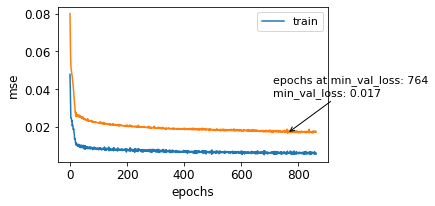

cc of val: 0.8479428855538147


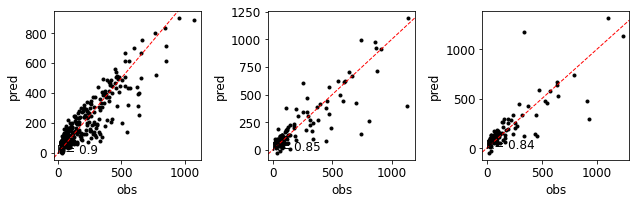

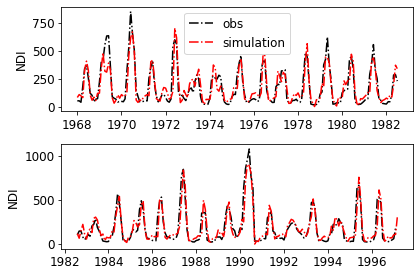

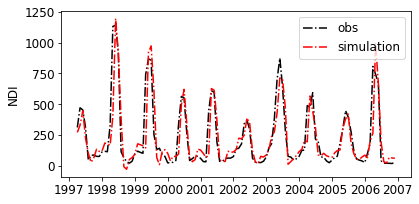

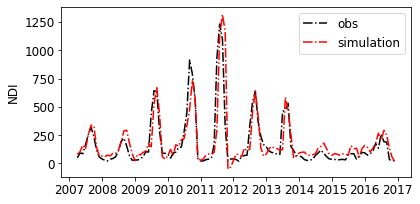

59.61435204207048
80.52744528648181
71.7231605748364


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AAA_hybrid_separate')
%run all_functions.ipynb
# tao ra cac thu muc con
namex='T1M1_runoff'
outs=[namex+'/'+'save_model',
      namex+'/'+'save_pickles',
      namex+'/'+'tables',
      namex+'/'+'figs',
      namex+'/'+'loss']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)
import pickle
# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)

# import pandas as pd
df_all=pd.DataFrame(columns=['NAME','CC1','MAE1','CC2','MAE1','CC3','MAE3'],index=range(14))

##
###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names=['T1M1','T1M2','T1M3']
k=29
n_in0=3
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
# -----------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
# Chi lay NDI3 khac voi cac kich ban M3
df1=df0.iloc[:(2016-1968+1)*12,-3]

# df1
# =============================================================================

df2=series_to_supervised_df(pd.DataFrame(df1),n_in0,n_out0)
df2

#################################################################################
df4=df2
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]
# print(train_df.shape,val_df.shape,test_df.shape)
x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
# x_train,y_train0=train_df.iloc[:,:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
# x_val,y_val0=val_df.iloc[:,:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)
# n_features=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))

"""# Decide characters or time steps"""

# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
n_features=1 # cai nay dung hon
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))

# # TH2: xem no nhu 12 dac tinh
# n_step=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
# print(train_X.shape)

"""# Define model and setup training, save models

"""
if 'model' in locals(): # xoa di cac model tam thoi de khong bi anh huong bo nho
  # myVar exists.
  del model
tf.keras.backend.clear_session() # tranh viec chay di nhieu lan se lap lai cac lop
mape = tf.keras.losses.MeanAbsolutePercentageError()
# =============================================================================
# TH1:
n_features = train_X.shape[2]
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(n_in0, n_features)))
# model.add(LSTM(32))
model.add(Dense(y_train.shape[1]))
# =============================================================================
# =============================================================================
# # Define model
# # TH2:
# model = Sequential()
# model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
model.compile(optimizer=opt, loss='mse')
model.summary()

"""# Define callbacks"""

# Tao cac call back khac nhau 
###############################################################################
# NAME="T4-M1-TB-{}".format(int(time.time()))
NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
tensorboard_callback1=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
                                                     histogram_freq=1) # ket hop 
#####**************************************************
## IMPORTNANT 
# conditional call back
value00=0.028 # cho validation
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=value00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

###############
# condtion for training
# conditional call back
value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
from keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=value0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
    
    
  
##### callbacks
callbacks_list = [
# callbacks_threshole_val,
 # stopping
keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=100,
mode="min",
),

###################################################################

# checkpoint
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
),
# tensorboard,
tensorboard_callback1,
]
######################################################################
#

"""# TRAINING MODEL"""

## KHONG TRAINING NUA
# set seed de ket qua model khong bi thay doi
seed=123456789
import random
# import numpy as np
# import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
### == FITTING MODEL ##############################
# Fit model can bo sung them batchsize

history=model.fit(train_X,
          y_train_scale,
epochs=1500,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale),
batch_size=36,sample_weight=None,
steps_per_epoch=12,
initial_epoch=10,
)


# # Save loss training
# # save loss training 
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


"""# Load results"""
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl',  'rb') as f3:
    # compressed_file = bz2.BZ2File(f, 'r')
    history = pickle.load(f3)

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras")
print("Loaded model from disk")



"""# Draw graphics"""

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

##########################################################
# Validation
pred = loaded_model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs

# ################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#
# THONG KE TAI DAY 
df_all_hinh=pd.DataFrame(columns=['NAME','CC1',
                                  'MAE1','CC2','MAE2',
                                  'CC3','MAE3'],index=range(14))
#--------------------------------------------------------------------#
df_all_hinh['NAME'][0]='T3M1'
# train
R1,ci1=pearsonr(obs1.flatten(),pred1.flatten())
MAE1=metrics.mean_absolute_error(obs1,pred1)
df_all_hinh['CC1'][0]=R1
df_all_hinh['MAE1'][0]=MAE1
# # val
# R2,ci2=pearsonr(obs2.flatten(),pred2.flatten())
# MAE2=metrics.mean_absolute_error(obs2,pred2)
# df_all_hinh['CC2'][0]=R2
# df_all_hinh['MAE2'][0]=MAE2
# test
R3,ci3=pearsonr(obs3.flatten(),pred3.flatten())
MAE3=metrics.mean_absolute_error(obs3,pred3)
df_all_hinh['CC3'][0]=R3
df_all_hinh['MAE3'][0]=MAE3
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# namex='T1M1_lag24'
df_train.to_csv('all_ts'+'/'+"train_"+ namex+'.csv')
df_val.to_csv('all_ts'+'/'+"val_"+ namex+'.csv')
df_test.to_csv('all_ts'+'/'+"test_"+ namex+'.csv')
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','val','testing']
CC=[]
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2

  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-5.9
    max_values=2.29

    # plt.xlim(min_values,max_values)
    # plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    CC.append(r2_vanila_1m)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  # plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  # plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  # plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'val_time_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # TEST*************************************************************************
  
#Graph
months=['1month','2months','3months']
# for lead_time in range(1):
lead_time=0
fig,ax=plt.subplots(figsize=(6,3))
plt.subplot(111)
plt.rcParams.update({'font.size': 12})
# plt.ylim([-6.0,2.3])
vector_date_test=vector_date[-24:]
plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
ts_T3M1=pred3[:,lead_time]
ts_T3M1obs=obs3[:,lead_time]
  # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
# plt.title('Time series '+'1month' +' lead time prediction at testing')
plt.tight_layout() 

plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'test_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
# =============================================================================
# Xuat me table o day

"""# LOAD  TENSORFBOARD"""

# %tensorboard --logdir logs/T4-M1-TB-2021/

# Tinh MAE
MAE_train=mean_absolute_error(obs1,pred1)
print(MAE_train)
MAE_val=mean_absolute_error(obs2,pred2)
print(MAE_val)
MAE_test=mean_absolute_error(obs,pred3)
print(MAE_test)

"""# XUAT KET QUA RA CSV"""

# nhap thu vien tinh sai so
from sklearn import metrics
from scipy.stats import pearsonr
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
name_model=[]
mae=[]
rmse=[]
mape=[]
NSE=[]
# R2=[]
CC=[]
names_models=['training','validation','testing']
for i in range(3):
  # phases.append(phase_cho[i])
  name_model.append(names_models[i])
  # CC.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  mae.append(metrics.median_absolute_error(list_con[i]['obs'],list_con[i]['pred']))
  rmse.append(np.sqrt(metrics.mean_squared_error(list_con[i]['obs'],list_con[i]['pred'])))
  mape.append(np.sqrt(metrics.mean_absolute_percentage_error(list_con[i]['obs'],list_con[i]['pred'])))
  # R2.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  NSE.append(nse(list_con[i]['obs'],list_con[i]['pred']))
  list_con[i].to_csv(outs[2]+'/'+names[n_out0-1]+names_models[i]+'.csv')

###################
df_error=pd.DataFrame({'name_model':name_model,
'mae':mae,
'rmse':rmse,
'mape':mape,
'NSE':NSE,
# 'R2':R2,
# 'CC':CC,
})
# print(df_error)
# df_error.to_csv(outs[2]+'/'+names[n_out0-1]+'.csv')
# df_all.iloc[0,0]='T1M1'
# # df_all.iloc[0,1]=df_error.iloc[0,5]
# df_all.iloc[0,2]=df_error.iloc[0,1]
# df_all.iloc[0,3]=df_error.iloc[1,5]
# df_all.iloc[0,4]=df_error.iloc[1,1]
# df_all.iloc[0,5]=df_error.iloc[2,5]
# df_all.iloc[0,6]=df_error.iloc[2,1]
# print(df_all)

## Prediction soil moisture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 11/1500
12/12 [==============================] - 2s 67ms/step - loss: 0.3164 - val_loss: 0.3171
Epoch 12/1500
12/12 [==============================] - 0s 11ms/step - loss: 0.2588 - val_loss: 0.2697
Epoch 13/1500
12/12 [==============================] - 0s 13ms/step - loss: 0.2290 - val_loss: 0.2234
Epoch 14/1500
12/12 [==============================] - 0s 12ms/step - loss: 0.1750 - val_loss: 0.1783
Epoch 15/1500
12/12 [=====================

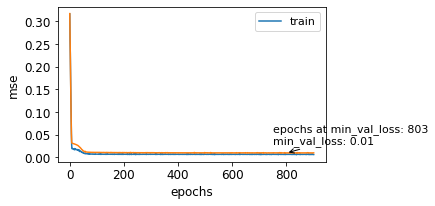

cc of val: 0.8862909514532561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


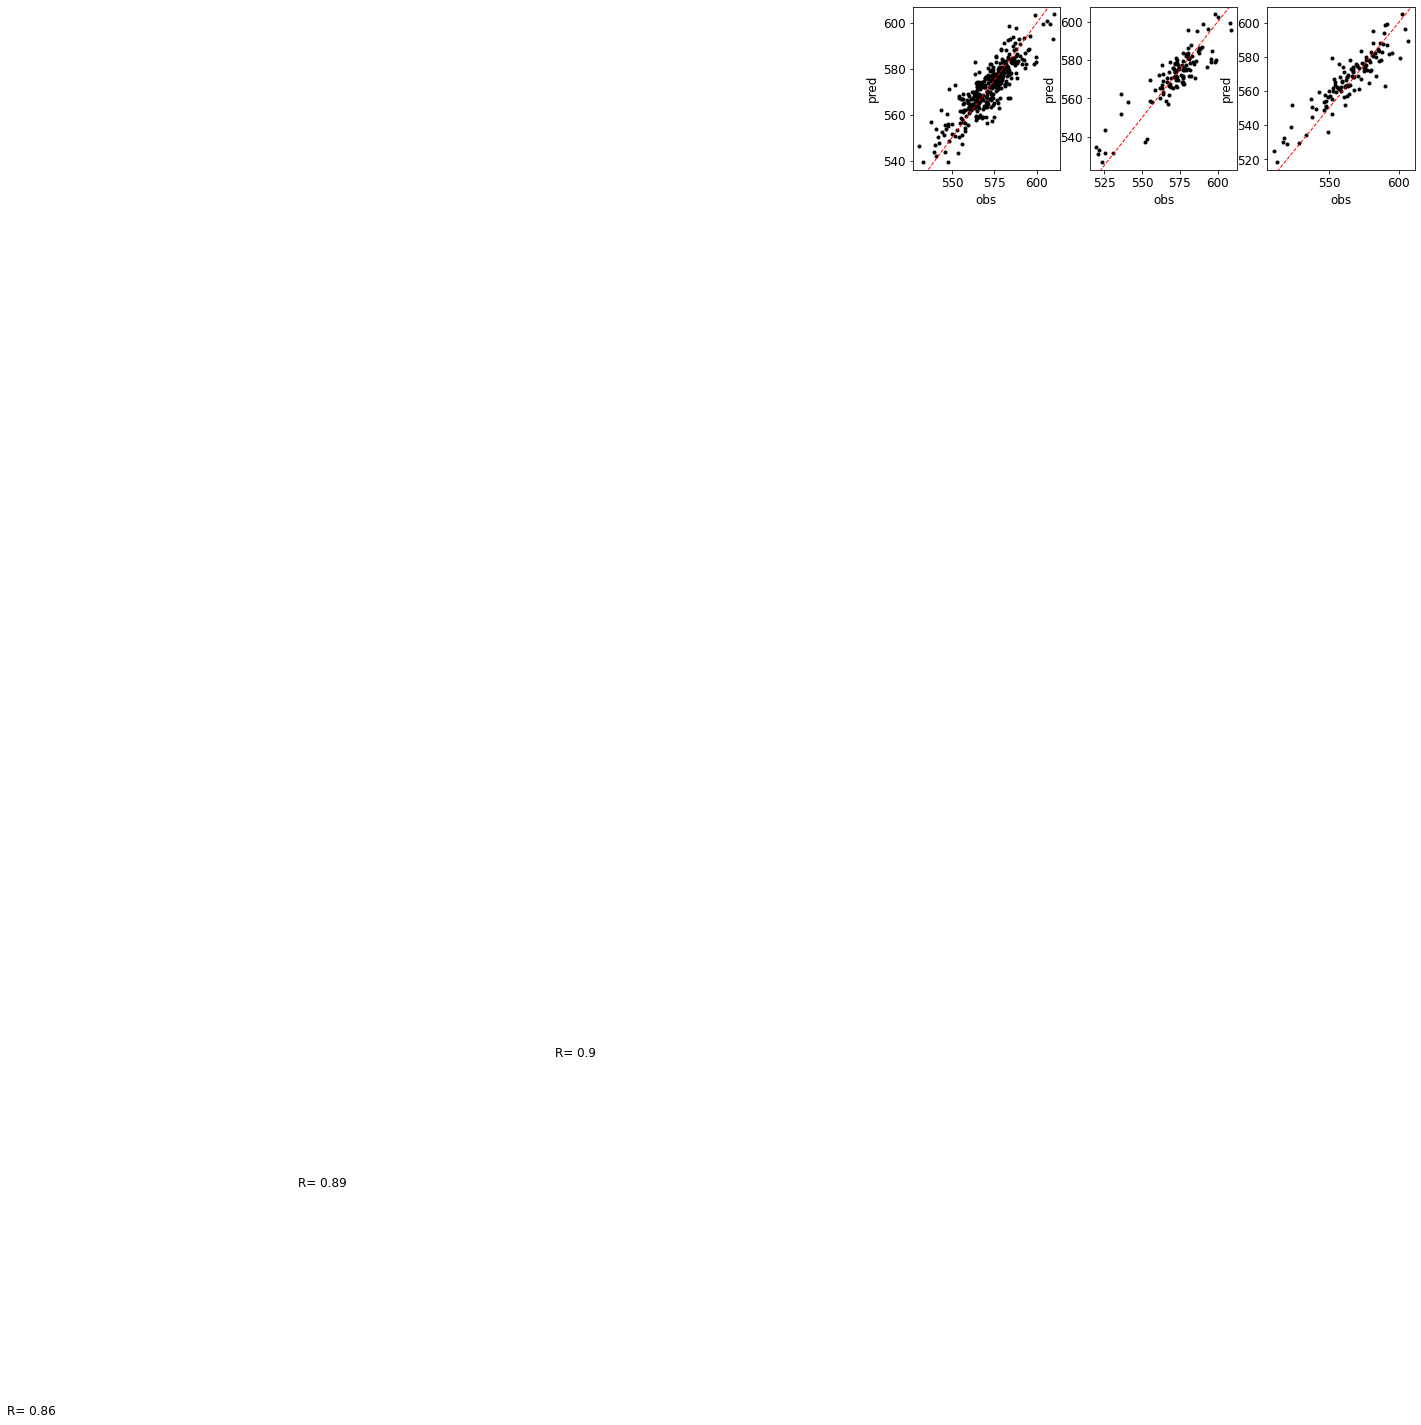

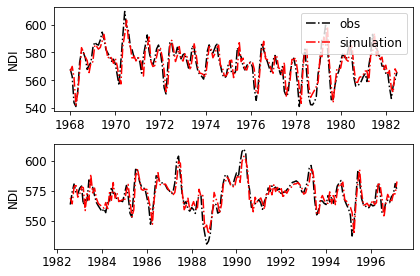

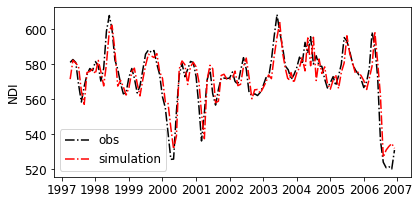

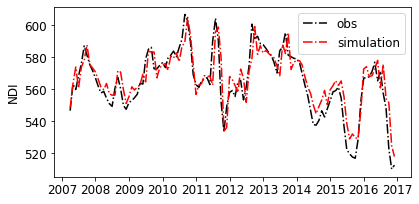

5.117418355479878
6.152852292835201
6.992525654658567


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AAA_hybrid_separate')
%run all_functions.ipynb
# tao ra cac thu muc con
namex='T1M1_soil_moisture'
outs=[namex+'/'+'save_model',
      namex+'/'+'save_pickles',
      namex+'/'+'tables',
      namex+'/'+'figs',
      namex+'/'+'loss']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)
import pickle
# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)

# import pandas as pd
df_all=pd.DataFrame(columns=['NAME','CC1','MAE1','CC2','MAE1','CC3','MAE3'],index=range(14))

##
###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names=['T1M1','T1M2','T1M3']
k=29
n_in0=3
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
# -----------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
# Chi lay NDI3 khac voi cac kich ban M3
df1=df0.iloc[:(2016-1968+1)*12,-2]

# df1
# =============================================================================

df2=series_to_supervised_df(pd.DataFrame(df1),n_in0,n_out0)
df2

#################################################################################
df4=df2
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]
# print(train_df.shape,val_df.shape,test_df.shape)
x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
# x_train,y_train0=train_df.iloc[:,:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
# x_val,y_val0=val_df.iloc[:,:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)
# n_features=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))

"""# Decide characters or time steps"""

# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
n_features=1 # cai nay dung hon
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], n_features))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], n_features))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], n_features))

# # TH2: xem no nhu 12 dac tinh
# n_step=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
# print(train_X.shape)

"""# Define model and setup training, save models

"""
if 'model' in locals(): # xoa di cac model tam thoi de khong bi anh huong bo nho
  # myVar exists.
  del model
tf.keras.backend.clear_session() # tranh viec chay di nhieu lan se lap lai cac lop
mape = tf.keras.losses.MeanAbsolutePercentageError()
# =============================================================================
# TH1:
n_features = train_X.shape[2]
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(n_in0, n_features)))
# model.add(LSTM(32))
model.add(Dense(y_train.shape[1]))
# =============================================================================
# =============================================================================
# # Define model
# # TH2:
# model = Sequential()
# model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
model.compile(optimizer=opt, loss='mse')
model.summary()

"""# Define callbacks"""

# Tao cac call back khac nhau 
###############################################################################
# NAME="T4-M1-TB-{}".format(int(time.time()))
NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
tensorboard_callback1=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
                                                     histogram_freq=1) # ket hop 
#####**************************************************
## IMPORTNANT 
# conditional call back
value00=0.028 # cho validation
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=value00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

###############
# condtion for training
# conditional call back
value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
from keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=value0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
    
    
  
##### callbacks
callbacks_list = [
# callbacks_threshole_val,
 # stopping
keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=100,
mode="min",
),

###################################################################

# checkpoint
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
),
# tensorboard,
tensorboard_callback1,
]
######################################################################
#

"""# TRAINING MODEL"""

## KHONG TRAINING NUA
# set seed de ket qua model khong bi thay doi
seed=123456789
import random
# import numpy as np
# import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
### == FITTING MODEL ##############################
# Fit model can bo sung them batchsize

history=model.fit(train_X,
          y_train_scale,
epochs=1500,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale),
batch_size=36,sample_weight=None,
steps_per_epoch=12,
initial_epoch=10,
)


# # Save loss training
# # save loss training 
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


"""# Load results"""
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl',  'rb') as f3:
    # compressed_file = bz2.BZ2File(f, 'r')
    history = pickle.load(f3)

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras")
print("Loaded model from disk")



"""# Draw graphics"""

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

##########################################################
# Validation
pred = loaded_model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs

# ################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#
# THONG KE TAI DAY 
df_all_hinh=pd.DataFrame(columns=['NAME','CC1',
                                  'MAE1','CC2','MAE2',
                                  'CC3','MAE3'],index=range(14))
#--------------------------------------------------------------------#
df_all_hinh['NAME'][0]='T3M1'
# train
R1,ci1=pearsonr(obs1.flatten(),pred1.flatten())
MAE1=metrics.mean_absolute_error(obs1,pred1)
df_all_hinh['CC1'][0]=R1
df_all_hinh['MAE1'][0]=MAE1
# # val
# R2,ci2=pearsonr(obs2.flatten(),pred2.flatten())
# MAE2=metrics.mean_absolute_error(obs2,pred2)
# df_all_hinh['CC2'][0]=R2
# df_all_hinh['MAE2'][0]=MAE2
# test
R3,ci3=pearsonr(obs3.flatten(),pred3.flatten())
MAE3=metrics.mean_absolute_error(obs3,pred3)
df_all_hinh['CC3'][0]=R3
df_all_hinh['MAE3'][0]=MAE3
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# namex='T1M1_lag24'
df_train.to_csv('all_ts'+'/'+"train_"+ namex+'.csv')
df_val.to_csv('all_ts'+'/'+"val_"+ namex+'.csv')
df_test.to_csv('all_ts'+'/'+"test_"+ namex+'.csv')
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','val','testing']
CC=[]
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2

  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-5.9
    max_values=2.29

    # plt.xlim(min_values,max_values)
    # plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    CC.append(r2_vanila_1m)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  # plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  # plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  # plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'val_time_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # TEST*************************************************************************
  
#Graph
months=['1month','2months','3months']
# for lead_time in range(1):
lead_time=0
fig,ax=plt.subplots(figsize=(6,3))
plt.subplot(111)
plt.rcParams.update({'font.size': 12})
# plt.ylim([-6.0,2.3])
vector_date_test=vector_date[-24:]
plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
ts_T3M1=pred3[:,lead_time]
ts_T3M1obs=obs3[:,lead_time]
  # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
# plt.title('Time series '+'1month' +' lead time prediction at testing')
plt.tight_layout() 

plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'test_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
# =============================================================================
# Xuat me table o day

"""# LOAD  TENSORFBOARD"""

# %tensorboard --logdir logs/T4-M1-TB-2021/

# Tinh MAE
MAE_train=mean_absolute_error(obs1,pred1)
print(MAE_train)
MAE_val=mean_absolute_error(obs2,pred2)
print(MAE_val)
MAE_test=mean_absolute_error(obs,pred3)
print(MAE_test)

"""# XUAT KET QUA RA CSV"""

# nhap thu vien tinh sai so
from sklearn import metrics
from scipy.stats import pearsonr
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
name_model=[]
mae=[]
rmse=[]
mape=[]
NSE=[]
# R2=[]
CC=[]
names_models=['training','validation','testing']
for i in range(3):
  # phases.append(phase_cho[i])
  name_model.append(names_models[i])
  # CC.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  mae.append(metrics.median_absolute_error(list_con[i]['obs'],list_con[i]['pred']))
  rmse.append(np.sqrt(metrics.mean_squared_error(list_con[i]['obs'],list_con[i]['pred'])))
  mape.append(np.sqrt(metrics.mean_absolute_percentage_error(list_con[i]['obs'],list_con[i]['pred'])))
  # R2.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  NSE.append(nse(list_con[i]['obs'],list_con[i]['pred']))
  list_con[i].to_csv(outs[2]+'/'+names[n_out0-1]+names_models[i]+'.csv')

###################
df_error=pd.DataFrame({'name_model':name_model,
'mae':mae,
'rmse':rmse,
'mape':mape,
'NSE':NSE,
# 'R2':R2,
# 'CC':CC,
})
# print(df_error)
# df_error.to_csv(outs[2]+'/'+names[n_out0-1]+'.csv')
# df_all.iloc[0,0]='T1M1'
# # df_all.iloc[0,1]=df_error.iloc[0,5]
# df_all.iloc[0,2]=df_error.iloc[0,1]
# df_all.iloc[0,3]=df_error.iloc[1,5]
# df_all.iloc[0,4]=df_error.iloc[1,1]
# df_all.iloc[0,5]=df_error.iloc[2,5]
# df_all.iloc[0,6]=df_error.iloc[2,1]
# print(df_all)

## Prepare input_NDI

In [ ]:
import os
os.chdir('/content/drive/MyDrive/AAA_hybrid_separate')
%run all_functions.ipynb
# read precipitation
df_p=pd.read_csv('T1M1_precipitation/tables/T1M1testing.csv')
df_r=pd.read_csv('T1M1_runoff/tables/T1M1testing.csv')
df_s=pd.read_csv('T1M1_soil_moisture/tables/T1M1testing.csv')

arr_prs=np.zeros([df_p.shape[0],3])
arr_prs[:,0]=df_p.pred
arr_prs[:,1]=df_r.pred
arr_prs[:,2]=df_s.pred
arr_prs.shape
pd.date_range(end='2016-12',freq='MS',periods=arr_prs.shape[0])
# Tinh tu 2008.01-2016.12 , indx tu 9
arr_prs1=arr_prs[9:,:].copy()
arr_prs1.shape
arr_prs2=arr_prs1.reshape(int(arr_prs1.shape[0]/12),int(arr_prs1.shape[1]*12))
arr_prs2.shape
x_date=pd.date_range(end='2017',freq='Y',periods=arr_prs2.shape[0])
import datetime
x_date.year
# type(x_date)
df10=pd.DataFrame(arr_prs2,index=x_date.year)
df10
arr_prs3=np.zeros([9,37])
arr_prs3[:,0]=x_date.year
arr_prs3[:,1:]=arr_prs2

df11=pd.DataFrame(np.abs(arr_prs3))
# df11
# doc ten file
file_names=pd.read_csv('forcing_name_hanst.txt',
                       header=None,delim_whitespace=True,  )

# print(file_names)
file_name_mon=file_names.iloc[:,0].values
file_name_grid=file_names.iloc[:,3].values
# print(file_name_mon)
for k in range(59):
  df11.to_csv('04_mon_re_2008_2016'+'/'+str(file_name_grid[k])+'.txt',
                  header=False,
                  index=False,
                  float_format='%.2f',
                  sep=" ",
                  )


## Check after run matlab code

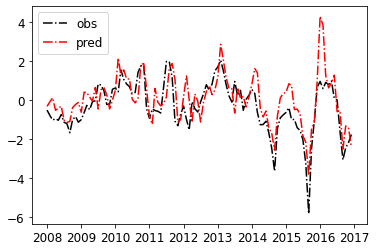

In [ ]:
NDI_forecast =pd.read_csv('/content/drive/MyDrive/re_computed_NDI2021/05_new_out_ndi_2008_2016/1mon/000201.txt',
                          header=None,
                          delim_whitespace=True)
NDI_forecast
df1=df0.iloc[(2007-1968+1)*12:(2016-1968+1)*12,-1]
df1
x_date1=pd.date_range(end='2016-12',freq='MS',periods=df1.shape[0])
plt.plot(x_date1,df1.values,'k-.')
plt.plot(x_date1,NDI_forecast.iloc[:,1].values,'r-.')
plt.legend(['obs','pred'])
plt.savefig('figs/'+'T1seperate'+'.jpeg',dpi=300)

# III) Compute PRS using both obs and climate

## precipitation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 7/300
12/12 [==============================] - 3s 90ms/step - loss: 0.0913 - val_loss: 0.1123
Epoch 8/300
12/12 [==============================] - 0s 18ms/step - loss: 0.0629 - val_loss: 0.0838
Epoch 9/300
12/12 [==============================] - 0s 18ms/step - loss: 0.0473 - val_loss: 0.0701
Epoch 10/300
12/

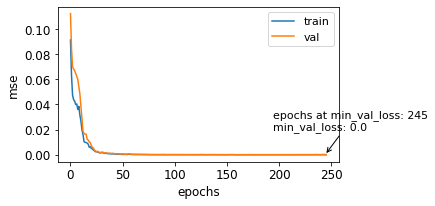

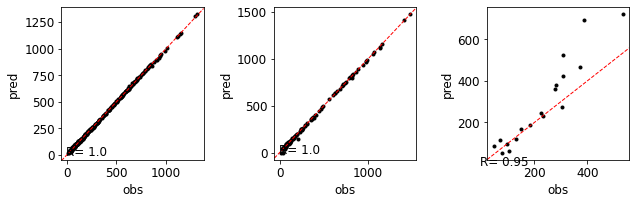

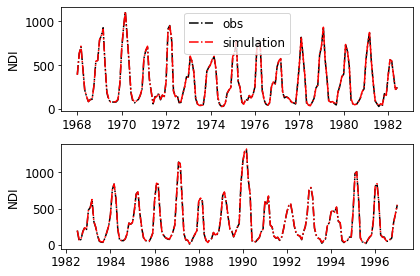

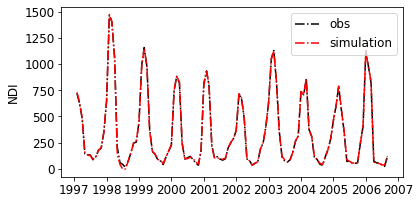

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:555: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


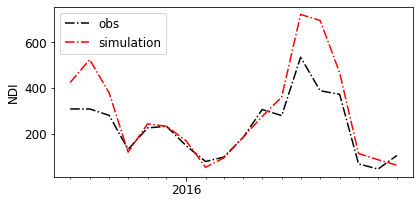

4.2323771518827495
5.996787653133785
74.30400873819987
   name_model        mae        rmse      mape       NSE        CC
0    training   3.198094    5.649919  0.191680  0.999582  0.999828
1  validation   3.018222   10.039917  0.257132  0.999165  0.999583
2     testing  41.722055  110.978296  0.569346  0.701636  0.945469


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AAA_hybrid_separate')
%run all_functions.ipynb
# tao ra cac thu muc con
namex='T5M1_lag60_precipitation'
outs=[namex+'/'+'save_model',
      namex+'/'+'save_pickles',
      namex+'/'+'tables',
      namex+'/'+'figs',
      namex+'/'+'loss']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)
import pickle
# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)


# Load mo hinh khi hau
m=0 # tinh cho 1 thang du bao
with open('input_pickles'+'/'+'PRS_NDIclim_sh.pkl', 'rb') as f2:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59kh = pickle.load(f2)[m]

# import pandas as pd
df_all=pd.DataFrame(columns=['NAME','CC1','MAE1','CC2','MAE1','CC3','MAE3'],index=range(14))

##
###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names=['T1M1','T1M2','T1M3']
k=29
n_in0=6
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
df0kh=PRS3_NDI3_59kh[k] # 1968-2020
# -----------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
# Chi lay NDI3 khac voi cac kich ban M3
df1=df0.iloc[:(2016-1968+1)*12,-4]

df1kh=df0kh.iloc[9:,-4]
df1obs=df0.iloc[(2014-1968+1)*12:(2016-1968+1)*12,-4]
# df1
# =============================================================================

df2=series_to_supervised_df(pd.DataFrame(df1),n_in0,n_out0)
# df0kh

df2kh=series_to_supervised_df(pd.DataFrame(df1kh),n_in0,n_out0)
# Tinh cho 24 thang cuoi thoi
df2kh=df2kh.iloc[-24:,:]
#################################################################################

df4=df2
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]

# lay gia tri index de ve do thi
test_df_org=test_df
# print(train_df.shape,val_df.shape,test_df.shape)
# x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
x_train,y_train0=train_df.iloc[:,1:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

# x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
x_val,y_val0=val_df.iloc[:,1:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

# x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values
# # Replace the last values by climate in test data set
df2kh
test_df=test_df.iloc[-df2kh.shape[0]:,:] # Bio chi kiem tra dung giai doan co du lieu khi hau
y_test0=test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,1:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
#THAY DOI GIA TRI CUA X TAI T BANG GIA TRI CUA KHI HAU
x_test1=test_df.iloc[:,1:].values.copy()
x_test2=df2kh.iloc[:,1:].values.copy()
x_test1[:,-1]=x_test2[:,-1].copy()
x_test=x_test1.copy()
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)

"""# Decide characters or time steps"""

# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
n_features=1 # cai nay dung hon
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], y_train.shape[1]))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], y_val.shape[1]))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], y_test.shape[1]))

# # TH2: xem no nhu 12 dac tinh
# n_step=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
# print(train_X.shape)

"""# Define model and setup training, save models

"""
if 'model' in locals(): # xoa di cac model tam thoi de khong bi anh huong bo nho
  # myVar exists.
  del model
tf.keras.backend.clear_session() # tranh viec chay di nhieu lan se lap lai cac lop
mape = tf.keras.losses.MeanAbsolutePercentageError()
# =============================================================================
# TH1:
n_features = train_X.shape[2]
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
# model.add(LSTM(32))
model.add(Dense(y_train.shape[1]))
# =============================================================================
# =============================================================================
# # Define model
# # TH2:
# model = Sequential()
# model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
model.compile(optimizer=opt, loss='mse')
model.summary()

"""# Define callbacks"""

# Tao cac call back khac nhau 
###############################################################################
# NAME="T4-M1-TB-{}".format(int(time.time()))
NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
tensorboard_callback1=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
                                                     histogram_freq=1) # ket hop 
#####**************************************************
## IMPORTNANT 
# conditional call back
value00=0.028 # cho validation
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=value00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

###############
# condtion for training
# conditional call back
value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
from keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=value0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
    
    
  
##### callbacks
callbacks_list = [
# callbacks_threshole_val,
 # stopping
keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=100,
mode="min",
),

###################################################################

# checkpoint
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
),
# tensorboard,
tensorboard_callback1,
]
######################################################################
#

"""# TRAINING MODEL"""

## KHONG TRAINING NUA
# set seed de ket qua model khong bi thay doi
seed=123456789
import random
# import numpy as np
# import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
### == FITTING MODEL ##############################
# Fit model can bo sung them batchsize

history=model.fit(train_X,
          y_train_scale,
epochs=300,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale),
batch_size=36,sample_weight=None,
steps_per_epoch=12,
initial_epoch=6,
)


# # Save loss training
# # save loss training 
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


"""# Load results"""
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl',  'rb') as f3:
    # compressed_file = bz2.BZ2File(f, 'r')
    history = pickle.load(f3)

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras")
print("Loaded model from disk")



"""# Draw graphics"""

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

##########################################################
# Validation
pred = loaded_model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs

################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#
# THONG KE TAI DAY 
df_all_hinh=pd.DataFrame(columns=['NAME','CC1',
                                  'MAE1','CC2','MAE2',
                                  'CC3','MAE3'],index=range(14))
#--------------------------------------------------------------------#
df_all_hinh['NAME'][0]='T3M1'
# train
R1,ci1=pearsonr(obs1.flatten(),pred1.flatten())
MAE1=metrics.mean_absolute_error(obs1,pred1)
df_all_hinh['CC1'][0]=R1
df_all_hinh['MAE1'][0]=MAE1
# val
R2,ci2=pearsonr(obs2.flatten(),pred2.flatten())
MAE2=metrics.mean_absolute_error(obs2,pred2)
df_all_hinh['CC2'][0]=R2
df_all_hinh['MAE2'][0]=MAE2
# test
R3,ci3=pearsonr(obs3.flatten(),pred3.flatten())
MAE3=metrics.mean_absolute_error(obs3,pred3)
df_all_hinh['CC3'][0]=R3
df_all_hinh['MAE3'][0]=MAE3
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# namex='T1M1_lag24'
df_train.to_csv('all_ts'+'/'+"train_"+ namex+'.csv')
df_val.to_csv('all_ts'+'/'+"val_"+ namex+'.csv')
df_test.to_csv('all_ts'+'/'+"test_"+ namex+'.csv')
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
# pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
# print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','validation','testing']
CC=[]
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2

  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-5.9
    max_values=2.29

    # plt.xlim(min_values,max_values)
    # plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    CC.append(r2_vanila_1m)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  # plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  # plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  # plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'val_time_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # TEST*************************************************************************
test_df_org1=test_df_org.iloc[-pred3.shape[0]:,:]
test_df_org1['pred']=''
test_df_org1['pred']=pred3
test_df_org1
#Graph
months=['1month','2months','3months']
# for lead_time in range(1):
lead_time=0
fig,ax=plt.subplots(figsize=(6,3))
plt.subplot(111)
plt.rcParams.update({'font.size': 12})
# plt.ylim([-6.0,2.3])
# vector_date_test=vector_date[-24:]
# plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
# plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
# ts_T3M1=pred3[:,lead_time]
# ts_T3M1obs=obs3[:,lead_time]
plt.plot(test_df_org1.index.values.astype('datetime64',copy=False), test_df_org1['var1(t)'],'k-.')
plt.plot(test_df_org1.index.values.astype('datetime64',copy=False), test_df_org1['pred'],'r-.')
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')
# yearsFmt = DateFormatter('%Y-%m')
# yearsFmt = DateFormatter('%Y')
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

  # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
# plt.title('Time series '+'1month' +' lead time prediction at testing')
plt.tight_layout() 

plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'test_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
# =============================================================================
# Xuat me table o day

"""# LOAD  TENSORFBOARD"""

# %tensorboard --logdir logs/T4-M1-TB-2021/

# Tinh MAE
MAE_train=mean_absolute_error(obs1,pred1)
print(MAE_train)
MAE_val=mean_absolute_error(obs2,pred2)
print(MAE_val)
MAE_test=mean_absolute_error(obs,pred3)
print(MAE_test)

"""# XUAT KET QUA RA CSV"""

# nhap thu vien tinh sai so
from sklearn import metrics
from scipy.stats import pearsonr
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
name_model=[]
mae=[]
rmse=[]
mape=[]
NSE=[]
# R2=[]
# CC=[]
names_models=['training','validation','testing']
for i in range(3):
  # phases.append(phase_cho[i])
  name_model.append(names_models[i])
  # CC.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  mae.append(metrics.median_absolute_error(list_con[i]['obs'],list_con[i]['pred']))
  rmse.append(np.sqrt(metrics.mean_squared_error(list_con[i]['obs'],list_con[i]['pred'])))
  mape.append(np.sqrt(metrics.mean_absolute_percentage_error(list_con[i]['obs'],list_con[i]['pred'])))
  # R2.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  NSE.append(nse(list_con[i]['obs'],list_con[i]['pred']))
  list_con[i].to_csv(outs[2]+'/'+names[n_out0-1]+names_models[i]+'.csv')

###################
df_error=pd.DataFrame({'name_model':name_model,
'mae':mae,
'rmse':rmse,
'mape':mape,
'NSE':NSE,
# 'R2':R2,
'CC':CC,
})
print(df_error)
df_error.to_csv(outs[2]+'/'+names[n_out0-1]+'.csv')
df_all.iloc[0,0]='T1M1'
df_all.iloc[0,1]=df_error.iloc[0,5]
df_all.iloc[0,2]=df_error.iloc[0,1]
df_all.iloc[0,3]=df_error.iloc[1,5]
df_all.iloc[0,4]=df_error.iloc[1,1]
df_all.iloc[0,5]=df_error.iloc[2,5]
df_all.iloc[0,6]=df_error.iloc[2,1]

## runoff

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 7/300
12/12 [==============================] - 3s 91ms/step - loss: 0.0502 - val_loss: 0.0784
Epoch 8/300
12/12 [==============================] - 0s 17ms/step - loss: 0.0365 - val_loss: 0.0623
Epoch 9/300
12/12 [==============================] - 0s 18ms/step - loss: 0.0298 - val_loss: 0.0568
Epoch 10/300
12/

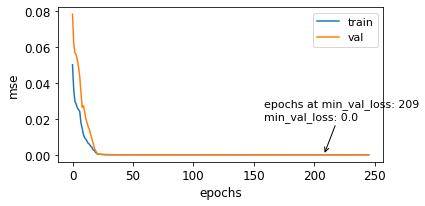

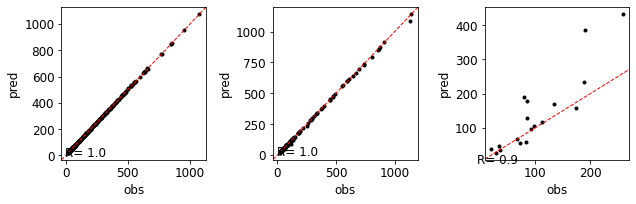

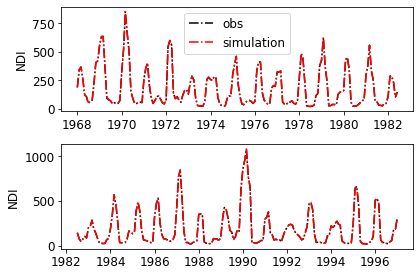

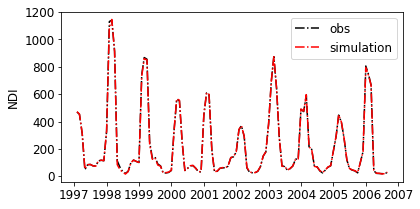

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:555: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


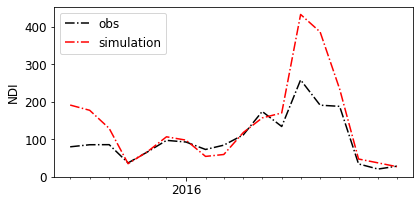

1.371036400781321
2.8754464419134727
45.334698627387155
   name_model        mae       rmse      mape       NSE        CC
0    training   1.157068   1.666528  0.146445  0.999922  0.999981
1  validation   1.526514   6.028661  0.176404  0.999459  0.999751
2     testing  17.903590  73.441550  0.640959  0.572632  0.895475


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AAA_hybrid_separate')
%run all_functions.ipynb
# tao ra cac thu muc con
namex='T5M1_lag60_runoff'
outs=[namex+'/'+'save_model',
      namex+'/'+'save_pickles',
      namex+'/'+'tables',
      namex+'/'+'figs',
      namex+'/'+'loss']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)
import pickle
# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)


# Load mo hinh khi hau
m=0 # tinh cho 1 thang du bao
with open('input_pickles'+'/'+'PRS_NDIclim_sh.pkl', 'rb') as f2:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59kh = pickle.load(f2)[m]

# import pandas as pd
df_all=pd.DataFrame(columns=['NAME','CC1','MAE1','CC2','MAE1','CC3','MAE3'],index=range(14))

##
###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names=['T1M1','T1M2','T1M3']
k=29
n_in0=6
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
df0kh=PRS3_NDI3_59kh[k] # 1968-2020
# -----------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
# Chi lay NDI3 khac voi cac kich ban M3
df1=df0.iloc[:(2016-1968+1)*12,-3] # THAY DOI O DAY

df1kh=df0kh.iloc[9:,-3] # THAY DOI O DAY
df1obs=df0.iloc[(2014-1968+1)*12:(2016-1968+1)*12,-3] # THAY DOI O DAY
# df1
# =============================================================================

df2=series_to_supervised_df(pd.DataFrame(df1),n_in0,n_out0)
# df0kh

df2kh=series_to_supervised_df(pd.DataFrame(df1kh),n_in0,n_out0)
# Tinh cho 24 thang cuoi thoi
df2kh=df2kh.iloc[-24:,:]
#################################################################################

df4=df2
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]

# lay gia tri index de ve do thi
test_df_org=test_df
# print(train_df.shape,val_df.shape,test_df.shape)
# x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
x_train,y_train0=train_df.iloc[:,1:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

# x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
x_val,y_val0=val_df.iloc[:,1:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

# x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values
# # Replace the last values by climate in test data set
df2kh
test_df=test_df.iloc[-df2kh.shape[0]:,:] # Bio chi kiem tra dung giai doan co du lieu khi hau
y_test0=test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,1:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
#THAY DOI GIA TRI CUA X TAI T BANG GIA TRI CUA KHI HAU
x_test1=test_df.iloc[:,1:].values.copy()
x_test2=df2kh.iloc[:,1:].values.copy()
x_test1[:,-1]=x_test2[:,-1].copy()
x_test=x_test1.copy()
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)

"""# Decide characters or time steps"""

# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
n_features=1 # cai nay dung hon
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], y_train.shape[1]))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], y_val.shape[1]))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], y_test.shape[1]))

# # TH2: xem no nhu 12 dac tinh
# n_step=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
# print(train_X.shape)

"""# Define model and setup training, save models

"""
if 'model' in locals(): # xoa di cac model tam thoi de khong bi anh huong bo nho
  # myVar exists.
  del model
tf.keras.backend.clear_session() # tranh viec chay di nhieu lan se lap lai cac lop
mape = tf.keras.losses.MeanAbsolutePercentageError()
# =============================================================================
# TH1:
n_features = train_X.shape[2]
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
# model.add(LSTM(32))
model.add(Dense(y_train.shape[1]))
# =============================================================================
# =============================================================================
# # Define model
# # TH2:
# model = Sequential()
# model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
model.compile(optimizer=opt, loss='mse')
model.summary()

"""# Define callbacks"""

# Tao cac call back khac nhau 
###############################################################################
# NAME="T4-M1-TB-{}".format(int(time.time()))
NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
tensorboard_callback1=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
                                                     histogram_freq=1) # ket hop 
#####**************************************************
## IMPORTNANT 
# conditional call back
value00=0.028 # cho validation
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=value00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

###############
# condtion for training
# conditional call back
value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
from keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=value0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
    
    
  
##### callbacks
callbacks_list = [
# callbacks_threshole_val,
 # stopping
keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=100,
mode="min",
),

###################################################################

# checkpoint
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
),
# tensorboard,
tensorboard_callback1,
]
######################################################################
#

"""# TRAINING MODEL"""

## KHONG TRAINING NUA
# set seed de ket qua model khong bi thay doi
seed=123456789
import random
# import numpy as np
# import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
### == FITTING MODEL ##############################
# Fit model can bo sung them batchsize

history=model.fit(train_X,
          y_train_scale,
epochs=300,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale),
batch_size=36,sample_weight=None,
steps_per_epoch=12,
initial_epoch=6,
)


# # Save loss training
# # save loss training 
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


"""# Load results"""
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl',  'rb') as f3:
    # compressed_file = bz2.BZ2File(f, 'r')
    history = pickle.load(f3)

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras")
print("Loaded model from disk")



"""# Draw graphics"""

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

##########################################################
# Validation
pred = loaded_model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs

################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#
# THONG KE TAI DAY 
df_all_hinh=pd.DataFrame(columns=['NAME','CC1',
                                  'MAE1','CC2','MAE2',
                                  'CC3','MAE3'],index=range(14))
#--------------------------------------------------------------------#
df_all_hinh['NAME'][0]='T3M1'
# train
R1,ci1=pearsonr(obs1.flatten(),pred1.flatten())
MAE1=metrics.mean_absolute_error(obs1,pred1)
df_all_hinh['CC1'][0]=R1
df_all_hinh['MAE1'][0]=MAE1
# val
R2,ci2=pearsonr(obs2.flatten(),pred2.flatten())
MAE2=metrics.mean_absolute_error(obs2,pred2)
df_all_hinh['CC2'][0]=R2
df_all_hinh['MAE2'][0]=MAE2
# test
R3,ci3=pearsonr(obs3.flatten(),pred3.flatten())
MAE3=metrics.mean_absolute_error(obs3,pred3)
df_all_hinh['CC3'][0]=R3
df_all_hinh['MAE3'][0]=MAE3
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# namex='T1M1_lag24'
df_train.to_csv('all_ts'+'/'+"train_"+ namex+'.csv')
df_val.to_csv('all_ts'+'/'+"val_"+ namex+'.csv')
df_test.to_csv('all_ts'+'/'+"test_"+ namex+'.csv')
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
# pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
# print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','validation','testing']
CC=[]
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2

  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-5.9
    max_values=2.29

    # plt.xlim(min_values,max_values)
    # plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    CC.append(r2_vanila_1m)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  # plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  # plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  # plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'val_time_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # TEST*************************************************************************
test_df_org1=test_df_org.iloc[-pred3.shape[0]:,:]
test_df_org1['pred']=''
test_df_org1['pred']=pred3
test_df_org1
#Graph
months=['1month','2months','3months']
# for lead_time in range(1):
lead_time=0
fig,ax=plt.subplots(figsize=(6,3))
plt.subplot(111)
plt.rcParams.update({'font.size': 12})
# plt.ylim([-6.0,2.3])
# vector_date_test=vector_date[-24:]
# plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
# plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
# ts_T3M1=pred3[:,lead_time]
# ts_T3M1obs=obs3[:,lead_time]
plt.plot(test_df_org1.index.values.astype('datetime64',copy=False), test_df_org1['var1(t)'],'k-.')
plt.plot(test_df_org1.index.values.astype('datetime64',copy=False), test_df_org1['pred'],'r-.')
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')
# yearsFmt = DateFormatter('%Y-%m')
# yearsFmt = DateFormatter('%Y')
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

  # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
# plt.title('Time series '+'1month' +' lead time prediction at testing')
plt.tight_layout() 

plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'test_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
# =============================================================================
# Xuat me table o day

"""# LOAD  TENSORFBOARD"""

# %tensorboard --logdir logs/T4-M1-TB-2021/

# Tinh MAE
MAE_train=mean_absolute_error(obs1,pred1)
print(MAE_train)
MAE_val=mean_absolute_error(obs2,pred2)
print(MAE_val)
MAE_test=mean_absolute_error(obs,pred3)
print(MAE_test)

"""# XUAT KET QUA RA CSV"""

# nhap thu vien tinh sai so
from sklearn import metrics
from scipy.stats import pearsonr
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
name_model=[]
mae=[]
rmse=[]
mape=[]
NSE=[]
# R2=[]
# CC=[]
names_models=['training','validation','testing']
for i in range(3):
  # phases.append(phase_cho[i])
  name_model.append(names_models[i])
  # CC.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  mae.append(metrics.median_absolute_error(list_con[i]['obs'],list_con[i]['pred']))
  rmse.append(np.sqrt(metrics.mean_squared_error(list_con[i]['obs'],list_con[i]['pred'])))
  mape.append(np.sqrt(metrics.mean_absolute_percentage_error(list_con[i]['obs'],list_con[i]['pred'])))
  # R2.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  NSE.append(nse(list_con[i]['obs'],list_con[i]['pred']))
  list_con[i].to_csv(outs[2]+'/'+names[n_out0-1]+names_models[i]+'.csv')

###################
df_error=pd.DataFrame({'name_model':name_model,
'mae':mae,
'rmse':rmse,
'mape':mape,
'NSE':NSE,
# 'R2':R2,
'CC':CC,
})
print(df_error)
df_error.to_csv(outs[2]+'/'+names[n_out0-1]+'.csv')
df_all.iloc[0,0]='T1M1'
df_all.iloc[0,1]=df_error.iloc[0,5]
df_all.iloc[0,2]=df_error.iloc[0,1]
df_all.iloc[0,3]=df_error.iloc[1,5]
df_all.iloc[0,4]=df_error.iloc[1,1]
df_all.iloc[0,5]=df_error.iloc[2,5]
df_all.iloc[0,6]=df_error.iloc[2,1]

## Soil moisture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 7/300
12/12 [==============================] - 4s 110ms/step - loss: 0.2725 - val_loss: 0.2541
Epoch 8/300
12/12 [==============================] - 0s 18ms/step - loss: 0.1929 - val_loss: 0.1643
Epoch 9/300
12/12 [==============================] - 0s 17ms/step - loss: 0.0925 - val_loss: 0.0509
Epoch 10/300
12

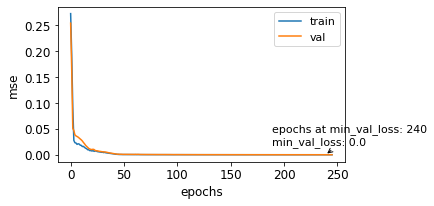

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:492: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


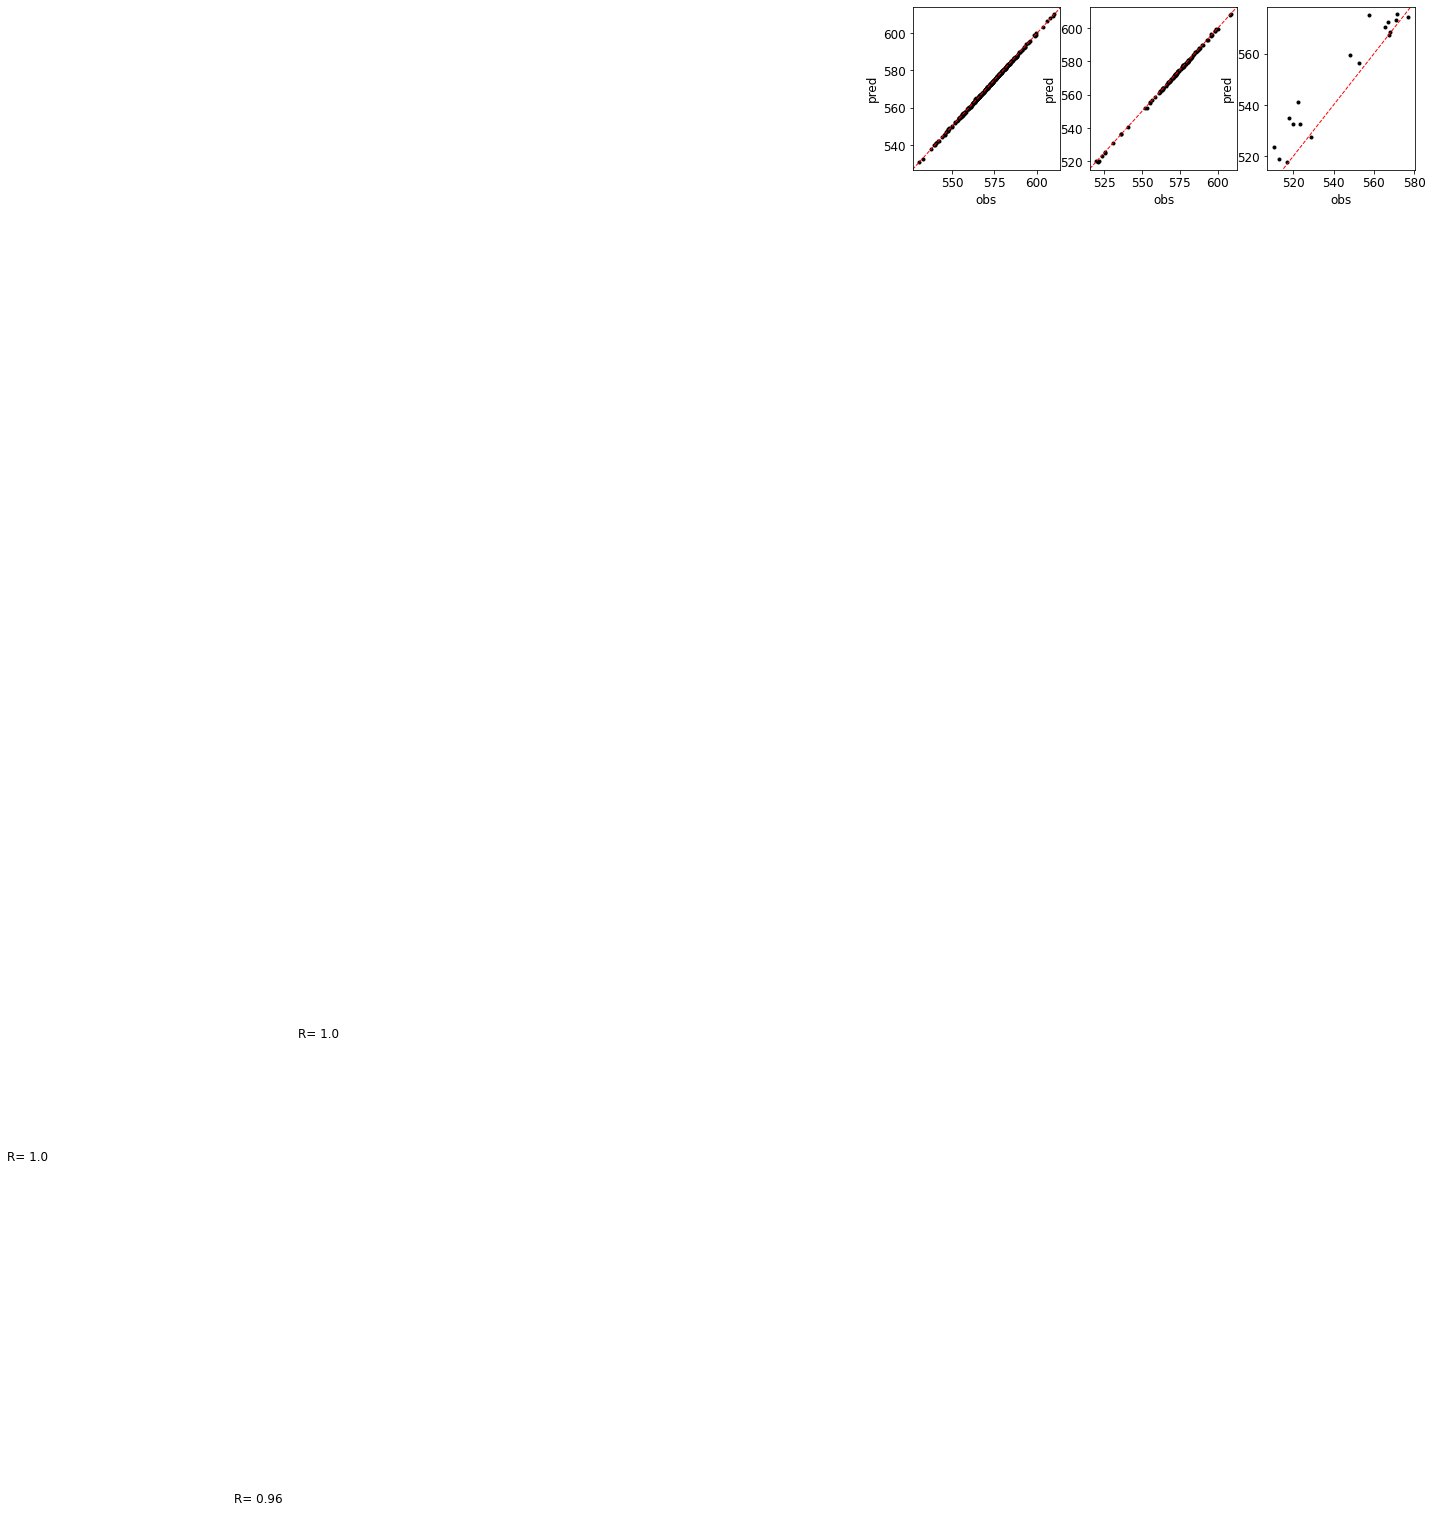

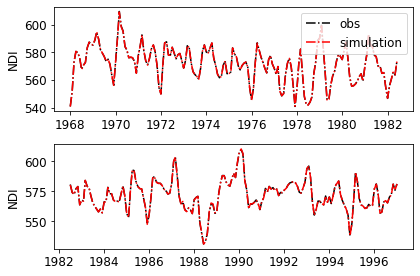

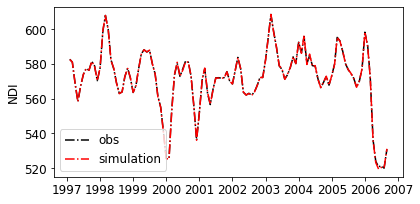

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:555: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


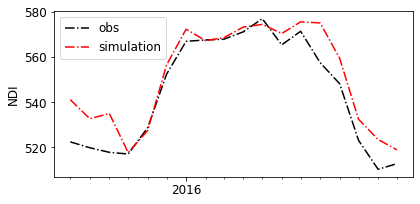

0.1485952959907781
0.19465675090921078
7.351777888093188
   name_model       mae      rmse      mape       NSE        CC
0    training  0.101890  0.216897  0.016123  0.999715  0.999859
1  validation  0.110085  0.297274  0.018553  0.999708  0.999875
2     testing  5.187243  9.559564  0.117328  0.799760  0.962768


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AAA_hybrid_separate')
%run all_functions.ipynb
# tao ra cac thu muc con
namex='T5M1_lag60_soil_moisture'
outs=[namex+'/'+'save_model',
      namex+'/'+'save_pickles',
      namex+'/'+'tables',
      namex+'/'+'figs',
      namex+'/'+'loss']
for out in outs:
  if not os.path.exists(out):
    os.makedirs(out)
import pickle
# Load du lieu
# load data obs
with open('input_pickles'+'/'+'PRS3_NDI3_59new.pkl', 'rb') as f1:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59 = pickle.load(f1)


# Load mo hinh khi hau
m=0 # tinh cho 1 thang du bao
with open('input_pickles'+'/'+'PRS_NDIclim_sh.pkl', 'rb') as f2:
    # compressed_file = bz2.BZ2File(f, 'r')
    PRS3_NDI3_59kh = pickle.load(f2)[m]

# import pandas as pd
df_all=pd.DataFrame(columns=['NAME','CC1','MAE1','CC2','MAE1','CC3','MAE3'],index=range(14))

##
###### CHOSEN STATION INPUT, LEAD TIME PREDICTION###############################    
# kiem tra cho ganghwa
names=['T1M1','T1M2','T1M3']
k=29
n_in0=6
n_out0=1
m=n_out0 # tinh cho buoc 0
df0=PRS3_NDI3_59[k] # 1968-2020
# chia du lieu cho 12 lay 6 phan cho train, 3 phan cho val, 3 phan cho test
df0kh=PRS3_NDI3_59kh[k] # 1968-2020
# -----------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
# Chi lay NDI3 khac voi cac kich ban M3
df1=df0.iloc[:(2016-1968+1)*12,-2] # THAY DOI O DAY

df1kh=df0kh.iloc[9:,-2] # THAY DOI O DAY
df1obs=df0.iloc[(2014-1968+1)*12:(2016-1968+1)*12,-2] # THAY DOI O DAY
# df1
# =============================================================================

df2=series_to_supervised_df(pd.DataFrame(df1),n_in0,n_out0)
# df0kh

df2kh=series_to_supervised_df(pd.DataFrame(df1kh),n_in0,n_out0)
# Tinh cho 24 thang cuoi thoi
df2kh=df2kh.iloc[-24:,:]
#################################################################################

df4=df2
n_train=int(df4.shape[0]*0.6)
n_val=int(df4.shape[0]*0.8)-n_train
n_test=df4.shape[0]-n_val-n_train

train_df=df4.iloc[0:n_train,:]
val_df=df4.iloc[n_train:n_train+n_val,:]
test_df=df4.iloc[n_train+n_val:,:]

# lay gia tri index de ve do thi
test_df_org=test_df
# print(train_df.shape,val_df.shape,test_df.shape)
# x_train,y_train0=train_df.iloc[:,:-1].values,train_df.iloc[:,-1].values
# lay chinh no du bao no luon
x_train,y_train0=train_df.iloc[:,1:].values,train_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
y_train=y_train0.reshape(y_train0.shape[0],1)
# print(x_train.shape,y_train.shape)

# x_val,y_val0=val_df.iloc[:,:-1].values,val_df.iloc[:,-1].values
x_val,y_val0=val_df.iloc[:,1:].values,val_df.iloc[:,-1].values #  KIEM TRA DU BAO CHO CHINH NO
y_val=y_val0.reshape(y_val0.shape[0],1)
# print(x_val.shape,y_val.shape)

# x_test,y_test0=test_df.iloc[:,:-1].values,test_df.iloc[:,-1].values
# # Replace the last values by climate in test data set
df2kh
test_df=test_df.iloc[-df2kh.shape[0]:,:] # Bio chi kiem tra dung giai doan co du lieu khi hau
y_test0=test_df.iloc[:,-1].values

# x_test,y_test0=test_df.iloc[:,1:].values,test_df.iloc[:,-1].values # KIEM TRA DU BAO CHO CHINH NO
#THAY DOI GIA TRI CUA X TAI T BANG GIA TRI CUA KHI HAU
x_test1=test_df.iloc[:,1:].values.copy()
x_test2=df2kh.iloc[:,1:].values.copy()
x_test1[:,-1]=x_test2[:,-1].copy()
x_test=x_test1.copy()
y_test=y_test0.reshape(y_test0.shape[0],1)
# print(x_test.shape,y_test.shape)

# =============================================================================


# =============================================================================
# Scale data
# tao 2 scaler rieng cho X, Y de invert cho de
scaler_x = MinMaxScaler(feature_range=(0.01, 0.99))
scaler_y = MinMaxScaler(feature_range=(0.01, 0.99))

x_train_scale = scaler_x.fit_transform(x_train)
y_train_scale = scaler_y.fit_transform(y_train)

# fit scale cua train cho val va test
x_val_scale=scaler_x.transform(x_val)
y_val_scale=scaler_y.transform(y_val)

x_test_scale=scaler_x.transform(x_test)
y_test_scale=scaler_y.transform(y_test)

"""# Decide characters or time steps"""

# Can xem lai 12 gia tri nay la buoc thoi gian 
# hay 12 gia tri duoc xem nhu feature
# # TH1 : Xem no nhu 12 buoc thoi gian
n_features=1 # cai nay dung hon
train_X = x_train_scale.reshape((x_train_scale.shape[0], x_train_scale.shape[1], y_train.shape[1]))
val_X = x_val_scale.reshape((x_val_scale.shape[0], x_val_scale.shape[1], y_val.shape[1]))
test_X = x_test_scale.reshape((x_test_scale.shape[0], x_test_scale.shape[1], y_test.shape[1]))

# # TH2: xem no nhu 12 dac tinh
# n_step=1
# train_X = x_train_scale.reshape((x_train_scale.shape[0],n_step, x_train_scale.shape[1]))
# val_X = x_val_scale.reshape((x_val_scale.shape[0], n_step,x_val_scale.shape[1]))
# test_X = x_test_scale.reshape((x_test_scale.shape[0], n_step,x_test_scale.shape[1]))
# print(train_X.shape)

"""# Define model and setup training, save models

"""
if 'model' in locals(): # xoa di cac model tam thoi de khong bi anh huong bo nho
  # myVar exists.
  del model
tf.keras.backend.clear_session() # tranh viec chay di nhieu lan se lap lai cac lop
mape = tf.keras.losses.MeanAbsolutePercentageError()
# =============================================================================
# TH1:
n_features = train_X.shape[2]
model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(x_train_scale.shape[1], y_train.shape[1])))
# model.add(LSTM(32))
model.add(Dense(y_train.shape[1]))
# =============================================================================
# =============================================================================
# # Define model
# # TH2:
# model = Sequential()
# model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
# # model.add(Bidirectional(LSTM(32, activation='relu')))
# model.add(Dense(1))
# # =============================================================================
# opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 0.999)
opt = Adam(learning_rate = 0.001,  beta_1=0.9, beta_2=0.999, epsilon=1e-07,clipnorm = 1.5)
model.compile(optimizer=opt, loss='mse')
model.summary()

"""# Define callbacks"""

# Tao cac call back khac nhau 
###############################################################################
# NAME="T4-M1-TB-{}".format(int(time.time()))
NAME1=names[n_out0-1]+"-{}".format(datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S"))
# tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
# path="logs/fit"+datetime.datetime.now().strftime("%Y/%m%d-%H-%M-%S") # luu logs
# tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=path,histogram_freq=1)
tensorboard_callback1=tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME1),
                                                     histogram_freq=1) # ket hop 
#####**************************************************
## IMPORTNANT 
# conditional call back
value00=0.028 # cho validation
from keras.callbacks import Callback
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=value00, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_val = EarlyStoppingByLossVal(monitor='val_loss', value=value00, verbose=1)

###############
# condtion for training
# conditional call back
value0=0.0025 # sai so 5 % mse=(ypred-yobs)^2
from keras.callbacks import Callback
class EarlyStoppingByLoss(Callback):
    def __init__(self, monitor='loss', value=value0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

callbacks_threshole_train = EarlyStoppingByLossVal(monitor='loss', value=value0, verbose=1)
    
    
  
##### callbacks
callbacks_list = [
# callbacks_threshole_val,
 # stopping
keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=100,
mode="min",
),

###################################################################

# checkpoint
keras.callbacks.ModelCheckpoint(
filepath=outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras", # cong them buoc thoi gian
monitor="val_loss",
save_best_only=True,
),
# tensorboard,
tensorboard_callback1,
]
######################################################################
#

"""# TRAINING MODEL"""

## KHONG TRAINING NUA
# set seed de ket qua model khong bi thay doi
seed=123456789
import random
# import numpy as np
# import tensorflow as tf
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
### == FITTING MODEL ##############################
# Fit model can bo sung them batchsize

history=model.fit(train_X,
          y_train_scale,
epochs=300,
callbacks=callbacks_list,
validation_data=(val_X,y_val_scale),
batch_size=36,sample_weight=None,
steps_per_epoch=12,
initial_epoch=6,
)


# # Save loss training
# # save loss training 
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


"""# Load results"""
with open(outs[4]+'/'+'trainHistoryDictT1M1.pkl',  'rb') as f3:
    # compressed_file = bz2.BZ2File(f, 'r')
    history = pickle.load(f3)

# LOAD KET QUA TOT NHAT
# =============================================================================
# Load results
loaded_model=load_model(outs[0]+"/"+names[n_out0-1]+str(k)+"lead"+str(m)+"best_stopT1M1.keras")
print("Loaded model from disk")



"""# Draw graphics"""

# =============================================================================
# DANH GIA
# =============================================================================
# TONG KET 
# DRAW LOSS CURVE
#Check the Loss curve
fig,ax=plt.subplots(figsize=(6,3))
plt.rcParams.update({'font.size': 11})
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# Draw the minimum epochs 
df_val_loss=pd.DataFrame({'val_loss':history['val_loss']})
# print(df_val_loss)
idxmin=df_val_loss[['val_loss']].idxmin().values
val_loss_min_values=df_val_loss.loc[idxmin,:].values.flatten()
print(idxmin,val_loss_min_values)
plt.annotate('epochs at min_val_loss: '+str(idxmin[0]+1)+'\n'+'min_val_loss: '+str(np.round(val_loss_min_values[0],3)),
             xy=(idxmin,val_loss_min_values), xycoords='data',
            xytext=(idxmin-50, val_loss_min_values+0.02), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )

plt.legend(['train','val'])
plt.xlabel('epochs')
plt.ylabel('mse')
# plt.title('learning rate of 1 month leadtime prdiction')
plt.tight_layout()
plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'loss_curve_T3'+str(m)+'.jpeg',dpi=300)
plt.show(fig)
plt.close(fig)
###################################################################################
#----------------------Important !!!!-----------------------#
pred = loaded_model.predict(train_X)  #(predicted)  
obs  = y_train_scale               #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred train, obs train
pred1=pred
obs1=obs

##########################################################
# Validation
pred = loaded_model.predict(val_X)  #(pred)  
obs  = y_val_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred2=pred
obs2=obs

################################################################
pred = loaded_model.predict(test_X)  #(pred)  
obs  = y_test_scale                 #(obs) 
#-----------------------------------------------------------#

#----------------------reverse scaling------------------------------#
#For training period
y_hat_rescaled  = scaler_y.inverse_transform(pred) #prediction value
y_rescaled = scaler_y.inverse_transform(obs)         #observed value

#Inverse scaled --> pred, obs  
pred = y_hat_rescaled
obs = y_rescaled

# pred1, obs1: pred val, obs val
pred3=pred
obs3=obs
#--------------------------------------------------------------------#
# THONG KE TAI DAY 
df_all_hinh=pd.DataFrame(columns=['NAME','CC1',
                                  'MAE1','CC2','MAE2',
                                  'CC3','MAE3'],index=range(14))
#--------------------------------------------------------------------#
df_all_hinh['NAME'][0]='T3M1'
# train
R1,ci1=pearsonr(obs1.flatten(),pred1.flatten())
MAE1=metrics.mean_absolute_error(obs1,pred1)
df_all_hinh['CC1'][0]=R1
df_all_hinh['MAE1'][0]=MAE1
# val
R2,ci2=pearsonr(obs2.flatten(),pred2.flatten())
MAE2=metrics.mean_absolute_error(obs2,pred2)
df_all_hinh['CC2'][0]=R2
df_all_hinh['MAE2'][0]=MAE2
# test
R3,ci3=pearsonr(obs3.flatten(),pred3.flatten())
MAE3=metrics.mean_absolute_error(obs3,pred3)
df_all_hinh['CC3'][0]=R3
df_all_hinh['MAE3'][0]=MAE3
#--------------------------------------------------------------------#

# TOM LAI
list_con=list()
df_train=pd.DataFrame({'obs':obs1.flatten(),'pred':pred1.flatten()})
list_con.append(df_train)
df_val=pd.DataFrame({'obs':obs2.flatten(),'pred':pred2.flatten()})
list_con.append(df_val)
df_test=pd.DataFrame({'obs':obs3.flatten(),'pred':pred3.flatten()})
list_con.append(df_test)
# =============================================================================
# SAVE RESULTS
# namex='T1M1_lag24'
df_train.to_csv('all_ts'+'/'+"train_"+ namex+'.csv')
df_val.to_csv('all_ts'+'/'+"val_"+ namex+'.csv')
df_test.to_csv('all_ts'+'/'+"test_"+ namex+'.csv')
# =============================================================================
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'wb') as f: # khong nen
  # compressed_file = bz2.BZ2File(f, 'w')
  pickle.dump(list_con, f)

#####
## mo kiem tra lai
with open(outs[1]+'/'+names[n_out0-1]+str(k)+'lead'+str(m)+'T4_lag3.pkl', 'rb') as f: # khong nen
    # compressed_file = bz2.BZ2File(f, 'r')
    load_list_con = pickle.load(f)
# 0,1,2 tuong ung voi train, val, test
# pearson,dotincay=pearsonr(load_list_con[1]['obs'],load_list_con[1]['pred'])
# print('cc of val: '+str(pearson))
# =============================================================================
# VE HINH
# =============================================================================
# HINH  SCATTER
# Ve hinh statter plot cua training, validation and testing

# scale plot M1


axes=[131,132,133]
obs_all=[obs1,obs2,obs3]
pred_all=[pred1,pred2,pred3]
# lead_time=0
names_phases=['training','validation','testing']
CC=[]
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(9,3))
  plt.rcParams.update({'font.size': 12})
# lead_time=2

  for phase in range(3):
  # for lead_time in range(3):

    plt.subplot(axes[phase])
    pearson,dotincay=pearsonr(load_list_con[phase]['obs'],load_list_con[phase]['pred'])
    r2_vanila_1m =pearson
    plt.rcParams.update({'font.size': 12})
    
    min_values=-5.9
    max_values=2.29

    # plt.xlim(min_values,max_values)
    # plt.ylim(min_values,max_values)

    plt.scatter(x=load_list_con[phase]['obs'],
                y=load_list_con[phase]['pred'],
                s=None,
                c='k', 
                marker='.', 
                cmap=None,
                norm=None,
                vmin=None, 
                vmax=None,
                alpha=None,            
                linewidths=None,
                edgecolors=None,plotnonfinite=False,data=None)

    # ve duong 45
    # plt.legend(['NDI'])
    plt.xlabel('obs')
    if lead_time==0:
      plt.ylabel('pred')
    # if lead_time==1:
    # plt.title('M1S4prs_prs '+names_phases[m])
    # add_identity(ax, color='r', ls='--')
    plt.text(min_values,min_values,'R= '+str(round(r2_vanila_1m,2)))
    CC.append(r2_vanila_1m)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=1, scalex=False, scaley=False)

    plt.tight_layout()

  plt.savefig(outs[3]+'/'+str(k)+'scatter_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()
# =============================================================================
#VE HINH TIME SERIES
# =============================================================================
  
  # Ve TRAIN ***************************************************************
# Time series cua train
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,4))
  plt.subplot(211)
  # plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
 
  vector_date=pd.date_range(start='1968-01',periods=df1.shape[0],freq='MS')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],obs1[0:int(obs1.shape[0]*0.5),lead_time],'k-.')
  plt.plot(vector_date[0+lead_time:lead_time+int(obs1.shape[0]*0.5)],pred1[0:int(obs1.shape[0]*0.5),lead_time],'r-.')

  plt.legend(['obs','simulation'])

  plt.ylabel('NDI')
  # plt.title('Time series '+'1 month' +' lead time prediction at trainning')
  plt.tight_layout()

  plt.subplot(212)
  # plt.ylim([-6.0,2.3])
  plt.rcParams.update({'font.size': 12})
  
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],obs1[int(obs1.shape[0]*0.5):int(obs1.shape[0]*1),lead_time],'k-.')
  plt.plot(vector_date[lead_time+int(obs1.shape[0]*0.5):lead_time+int(obs1.shape[0]*1)],pred1[int(pred1.shape[0]*0.5):int(pred1.shape[0]*1),lead_time],'r-.')
  plt.ylabel('NDI')
  plt.tight_layout()

plt.savefig(outs[3]+'/'+str(k)+'train_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
############ VAL **************************************************************
# Time series cua val
#Graph
months=['1month','2months','3months']
for lead_time in range(1):
  fig,ax=plt.subplots(figsize=(6,3))
  plt.subplot(111)
  plt.rcParams.update({'font.size': 12})
  # plt.ylim([-6.0,2.3])
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],obs2[:,lead_time],'k-.')
  plt.plot(vector_date[n_train+lead_time:n_train+lead_time+obs2.shape[0]],pred2[:,lead_time],'r-.')
  plt.legend(['obs','simulation'])
  plt.ylabel('NDI')
  plt.tight_layout()

  plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'val_time_T1'+str(m)+'.jpeg',dpi=300)
  plt.show()
  plt.close()

  # TEST*************************************************************************
test_df_org1=test_df_org.iloc[-pred3.shape[0]:,:]
test_df_org1['pred']=''
test_df_org1['pred']=pred3
test_df_org1
#Graph
months=['1month','2months','3months']
# for lead_time in range(1):
lead_time=0
fig,ax=plt.subplots(figsize=(6,3))
plt.subplot(111)
plt.rcParams.update({'font.size': 12})
# plt.ylim([-6.0,2.3])
# vector_date_test=vector_date[-24:]
# plt.plot(vector_date[-n_test:],obs3[:,lead_time],'k-.')
# plt.plot(vector_date[-n_test:],pred3[:,lead_time],'r-.')
# ts_T3M1=pred3[:,lead_time]
# ts_T3M1obs=obs3[:,lead_time]
plt.plot(test_df_org1.index.values.astype('datetime64',copy=False), test_df_org1['var1(t)'],'k-.')
plt.plot(test_df_org1.index.values.astype('datetime64',copy=False), test_df_org1['pred'],'r-.')
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')
# yearsFmt = DateFormatter('%Y-%m')
# yearsFmt = DateFormatter('%Y')
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

  # plt.xticks(['2015-01','2015-06','2015-12','2016-12'])
plt.legend(['obs','simulation'])

plt.ylabel('NDI')
# plt.title('Time series '+'1month' +' lead time prediction at testing')
plt.tight_layout() 

plt.savefig(outs[3]+'/'+names[n_out0-1]+str(k)+'test_time_T1'+str(m)+'.jpeg',dpi=300)
plt.show()
plt.close()
# =============================================================================
# Xuat me table o day

"""# LOAD  TENSORFBOARD"""

# %tensorboard --logdir logs/T4-M1-TB-2021/

# Tinh MAE
MAE_train=mean_absolute_error(obs1,pred1)
print(MAE_train)
MAE_val=mean_absolute_error(obs2,pred2)
print(MAE_val)
MAE_test=mean_absolute_error(obs,pred3)
print(MAE_test)

"""# XUAT KET QUA RA CSV"""

# nhap thu vien tinh sai so
from sklearn import metrics
from scipy.stats import pearsonr
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
name_model=[]
mae=[]
rmse=[]
mape=[]
NSE=[]
# R2=[]
# CC=[]
names_models=['training','validation','testing']
for i in range(3):
  # phases.append(phase_cho[i])
  name_model.append(names_models[i])
  # CC.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  mae.append(metrics.median_absolute_error(list_con[i]['obs'],list_con[i]['pred']))
  rmse.append(np.sqrt(metrics.mean_squared_error(list_con[i]['obs'],list_con[i]['pred'])))
  mape.append(np.sqrt(metrics.mean_absolute_percentage_error(list_con[i]['obs'],list_con[i]['pred'])))
  # R2.append(np.sqrt(metrics.r2_score(list_con[i]['obs'],list_con[i]['pred'])))
  NSE.append(nse(list_con[i]['obs'],list_con[i]['pred']))
  list_con[i].to_csv(outs[2]+'/'+names[n_out0-1]+names_models[i]+'.csv')

###################
df_error=pd.DataFrame({'name_model':name_model,
'mae':mae,
'rmse':rmse,
'mape':mape,
'NSE':NSE,
# 'R2':R2,
'CC':CC,
})
print(df_error)
df_error.to_csv(outs[2]+'/'+names[n_out0-1]+'.csv')
df_all.iloc[0,0]='T1M1'
df_all.iloc[0,1]=df_error.iloc[0,5]
df_all.iloc[0,2]=df_error.iloc[0,1]
df_all.iloc[0,3]=df_error.iloc[1,5]
df_all.iloc[0,4]=df_error.iloc[1,1]
df_all.iloc[0,5]=df_error.iloc[2,5]
df_all.iloc[0,6]=df_error.iloc[2,1]

## Prepare input_NDI

In [ ]:
import os
os.chdir('/content/drive/MyDrive/AAA_hybrid_separate')
%run all_functions.ipynb
# read precipitation
df_p=pd.read_csv('T5M1_lag60_precipitation/tables/T1M1testing.csv')
df_r=pd.read_csv('T5M1_lag60_runoff/tables/T1M1testing.csv')
df_s=pd.read_csv('T5M1_lag60_soil_moisture/tables/T1M1testing.csv')

arr_prs=np.zeros([df_p.shape[0],3])
arr_prs[:,0]=df_p.pred
arr_prs[:,1]=df_r.pred
arr_prs[:,2]=df_s.pred
arr_prs.shape
pd.date_range(end='2016-12',freq='MS',periods=arr_prs.shape[0])
# Tinh tu 2008.01-2016.12 , indx tu 9
arr_prs1=arr_prs[6:,:].copy()
arr_prs1.shape
arr_prs2=arr_prs1.reshape(int(arr_prs1.shape[0]/12),int(arr_prs1.shape[1]*12))
arr_prs2.shape
x_date=pd.date_range(end='2017',freq='Y',periods=arr_prs2.shape[0])
import datetime
x_date.year
# type(x_date)
df10=pd.DataFrame(arr_prs2,index=x_date.year)
df10
arr_prs3=np.zeros([1,37])
arr_prs3[:,0]=x_date.year
arr_prs3[:,1:]=arr_prs2

df11=pd.DataFrame(np.abs(arr_prs3))
# df11
# doc ten file
file_names=pd.read_csv('forcing_name_hanst.txt',
                       header=None,delim_whitespace=True,  )

# print(file_names)
file_name_mon=file_names.iloc[:,0].values
file_name_grid=file_names.iloc[:,3].values
# print(file_name_mon)
for k in range(59):
  df11.to_csv('04_mon_re_2008_2016A'+'/'+str(file_name_grid[k])+'.txt',
                  header=False,
                  index=False,
                  float_format='%.2f',
                  sep=" ",
                  )

## Check after run Matlab codes

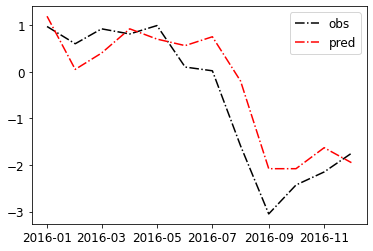

In [ ]:
NDI_forecast =pd.read_csv('/content/drive/MyDrive/re_computed_NDI2021/05_new_out_ndi_2008_2016A/1mon/000201.txt',
                          header=None,
                          delim_whitespace=True)
NDI_forecast
df1=df0.iloc[(2015-1968+1)*12:(2016-1968+1)*12,-1]
df1
x_date1=pd.date_range(end='2016-12',freq='MS',periods=df1.shape[0])
plt.plot(x_date1,df1.values,'k-.')
plt.plot(x_date1,NDI_forecast.iloc[:,1].values,'r-.')
plt.legend(['obs','pred'])
plt.savefig('figs/'+'T5seperate'+'.jpeg',dpi=300)